In [1]:
# 1. RGB Ïù¥ÎØ∏ÏßÄÏóêÏÑú DINOv2 ÌäπÏßï Ï∂îÏ∂ú
# 2. 2D keypoints ÏòàÏ∏° MLP ÌïôÏäµ
# 3. Joiot angle ÏòàÏ∏° MLP ÌïôÏäµ
# 4. FkÎ°ú 3D Ìè¨Ï¶à Í≥ÑÏÇ∞
# 5. 3D Ìè¨Ï¶àÏôÄ 2D keypoints PnPÎ°ú Ïπ¥Î©îÎùº Ìè¨Ï¶à Í≥ÑÏÇ∞
# 6. Extrinsic Matrix Í≥ÑÏÇ∞ Î∞è Ï†ÄÏû•

In [2]:
import os
import glob
import json
import numpy as np
import random
import wandb
import threading

import cv2
import math
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm 

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR # ÏÉÅÎã®Ïóê Ï∂îÍ∞Ä
import kornia.augmentation as K

from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

NUM_ANGLES = 7
NUM_JOINTS = 8
FEATURE_DIM = 768
HEATMAP_SIZE = (128, 128)

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
is_available = torch.cuda.is_available()

if is_available:
    # 2. ÏÇ¨Ïö© Í∞ÄÎä•Ìïú GPU Í∞úÏàò ÌôïÏù∏
    gpu_count = torch.cuda.device_count()
    print(f"‚úÖ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú GPUÍ∞Ä Í∞êÏßÄÎêòÏóàÏäµÎãàÎã§.")
    print(f"GPU Í∞úÏàò: {gpu_count}Í∞ú")

# --- ÏÑ§Ï†ï Î≥ÄÏàò ---
# CSV ÌååÏùºÏùò Ï†ÑÏ≤¥ Í≤ΩÎ°úÎ•º ÏßÄÏ†ïÌï©ÎãàÎã§.
TOTAL_CSV_PATH = '../dataset/franka_research3/fr3_matched_joint_angle.csv'

# --- 1. CSV ÌååÏùº Î°úÎìú ---
try:
    print(f"Loading data from {TOTAL_CSV_PATH}...")
    total_csv = pd.read_csv(TOTAL_CSV_PATH)
    print("‚úÖ CSV file loaded successfully.")
except FileNotFoundError:
    print(f"‚ùå ERROR: CSV file not found at {TOTAL_CSV_PATH}")
    exit() # ÌååÏùºÏù¥ ÏóÜÏúºÎ©¥ ÌîÑÎ°úÍ∑∏Îû® Ï¢ÖÎ£å

# --- 2. Îç∞Ïù¥ÌÑ∞ Ïåç Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî ---
dataset_pairs = []

# --- 3. CSVÏùò Í∞Å ÌñâÏùÑ ÏàúÌöåÌïòÎ©∞ Îç∞Ïù¥ÌÑ∞ Ïåç ÏÉùÏÑ± ---
# tqdmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÏßÑÌñâ ÏÉÅÌô©ÏùÑ ÌëúÏãúÌï©ÎãàÎã§.
print("Processing CSV rows to create dataset pairs...")
for index, row in tqdm(total_csv.iterrows(), total=len(total_csv), desc="Creating pairs"):
    # Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Ï∂îÏ∂ú
    image_path = row['image_path']
    
    # 7Í∞úÏùò Í¥ÄÏ†à ÏúÑÏπò(position) Í∞íÏùÑ Î¶¨Ïä§Ìä∏Î°ú Ï∂îÏ∂ú
    # Ïª¨Îüº Ïù¥Î¶Ñ (position_fr3_joint1, position_fr3_joint2, ...)
    try:
        joint_angles = [row[f'position_fr3_joint{j}'] for j in range(1, NUM_ANGLES + 1)]
        
        # Îç∞Ïù¥ÌÑ∞ ÏåçÏùÑ ÎîïÏÖîÎÑàÎ¶¨ ÌòïÌÉúÎ°ú ÏÉùÏÑ±
        pair = {
            'image_path': image_path,
            'joint_angles': joint_angles
        }
        
        # ÏµúÏ¢Ö Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
        dataset_pairs.append(pair)
        
    except KeyError as e:
        print(f"\n‚ö†Ô∏è Warning: Column not found ({e}), skipping row {index}.")


# --- 4. Í≤∞Í≥º ÌôïÏù∏ ---
print(f"\n‚úÖ Total {len(dataset_pairs)} pairs found.")

if dataset_pairs:
    print("\n--- Sample of matched pairs (first 5) ---")
    for i in range(min(5, len(dataset_pairs))):
        pair = dataset_pairs[i]
        # os.path.basenameÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌååÏùº Ïù¥Î¶ÑÎßå ÍπîÎÅîÌïòÍ≤å Ï∂úÎ†•
        print(f"Image: {os.path.basename(pair['image_path'])}")
        # joint_anglesÎäî ÏÜåÏàòÏ†ê 4ÏûêÎ¶¨ÍπåÏßÄÎßå ÌëúÏãú
        formatted_angles = [f"{angle:.4f}" for angle in pair['joint_angles']]
        print(f"Joint Angles: {formatted_angles}")
        print("-" * 20)

/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


‚úÖ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú GPUÍ∞Ä Í∞êÏßÄÎêòÏóàÏäµÎãàÎã§.
GPU Í∞úÏàò: 3Í∞ú
Loading data from ../dataset/franka_research3/fr3_matched_joint_angle.csv...
‚úÖ CSV file loaded successfully.
Processing CSV rows to create dataset pairs...


Creating pairs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16156/16156 [00:00<00:00, 18607.76it/s]


‚úÖ Total 16156 pairs found.

--- Sample of matched pairs (first 5) ---
Image: zed_49045152_left_1756275914.271.jpg
Joint Angles: ['0.6480', '-0.1083', '0.2098', '-1.9201', '0.8858', '3.1025', '-2.3876']
--------------------
Image: zed_49045152_right_1756275914.271.jpg
Joint Angles: ['0.6480', '-0.1083', '0.2098', '-1.9201', '0.8858', '3.1025', '-2.3876']
--------------------
Image: zed_41182735_right_1756275914.348.jpg
Joint Angles: ['0.6568', '-0.1068', '0.1993', '-1.9216', '0.8694', '3.0918', '-2.3762']
--------------------
Image: zed_41182735_left_1756275914.348.jpg
Joint Angles: ['0.6568', '-0.1068', '0.1993', '-1.9216', '0.8694', '3.0918', '-2.3762']
--------------------
Image: zed_49429257_right_1756275914.401.jpg
Joint Angles: ['0.6659', '-0.1053', '0.1888', '-1.9231', '0.8529', '3.0811', '-2.3646']
--------------------


In [3]:
def create_gt_heatmap(keypoint_2d, HEATMAP_SIZE, sigma):
    H, W = HEATMAP_SIZE
    x, y = keypoint_2d
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    dist_sq = (xx - x)**2 + (yy - y)**2
    exponent = dist_sq / (2 * sigma**2)
    heatmap = np.exp(-exponent)
    heatmap[heatmap < np.finfo(float).eps * heatmap.max()] = 0
    return heatmap

def get_modified_dh_matrix(a, d, alpha, theta):
    """CraigÏãù Modified DH: T = Rx(alpha) @ Tx(a) @ Rz(theta) @ Tz(d)"""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)

    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(alpha_rad), -np.sin(alpha_rad), 0],
        [0, np.sin(alpha_rad),  np.cos(alpha_rad), 0],
        [0, 0, 0, 1]
    ])
    Tx = np.array([
        [1, 0, 0, a],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    Rz = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0, 0],
        [np.sin(theta_rad),  np.cos(theta_rad), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    Tz = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, d],
        [0, 0, 0, 1]
    ])
    return Rx @ Tx @ Rz @ Tz

def angle_to_joint_coordinate(joint_angles, selected_view):
    """Converts 7 joint angles to 3D coordinates using forward kinematics."""
    # DH Parameters for Franka Research 3 (FR3) robot (meters and degrees)
    # IMPORTANT: Verify these parameters match your robot.
    fr3_dh_parameters = [
        {'a': 0,      'd': 0.333, 'alpha':   0, 'theta_offset': 0}, #1
        {'a': 0,      'd': 0,     'alpha': -90, 'theta_offset': 0}, #2
        {'a': 0,      'd': 0.316, 'alpha':  90, 'theta_offset': 0}, #3
        {'a': 0.0825,  'd': 0,     'alpha':  90, 'theta_offset': 0}, #4
        {'a': -0.0825, 'd': 0.384, 'alpha': -90, 'theta_offset': 0}, #5
        {'a': 0,      'd': 0,     'alpha':  90, 'theta_offset': 0}, #6
        {'a': 0.088,  'd': 0,     'alpha':  90, 'theta_offset': 0}, #7 
        {'a': 0,      'd': 0.107, 'alpha':   0, 'theta_offset': 0}  # flanger
    ]
    
    # Rotational correction for the robot base depending on the camera view
    view_rotations = {
        'view1': R.from_euler('zyx', [90, 180, 0], degrees=True), # Front (reference)
        'view4': R.from_euler('zyx', [90, 180, 0], degrees=True), # Top
        'view3': R.from_euler('zyx', [90, 180, 0], degrees=True), # Left
        'view2': R.from_euler('zyx', [90, 180, 0], degrees=True)  # Right
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (base) position
    
    base_point = np.array([[0], [0], [0], [1]])
    for i, angle_rad in enumerate(joint_angles):
        params = fr3_dh_parameters[i]
        theta_deg = math.degrees(angle_rad) + params['theta_offset']
        
        T_i = get_modified_dh_matrix(params['a'], params['d'], params['alpha'], theta_deg)
        T_cumulative = T_cumulative @ T_i
        
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
        
    return np.array(joint_coords_3d, dtype=np.float32)

def joint_coordinate_to_pixel_plane(coords_3d, aruco_result, camera_matrix, dist_coeffs):
    """Projects 3D coordinates onto the 2D image plane."""
    Rvec = np.array([
        aruco_result['rvec_x'],
        aruco_result['rvec_y'],
        aruco_result['rvec_z']
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    pixel_coords, _ = cv2.projectPoints(
        coords_3d, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

class RobotPoseDataset(Dataset):
    def __init__(self, pairs, transform=None, HEATMAP_SIZE=(128, 128), sigma=5.0):
        self.pairs = pairs
        self.transform = transform
        self.heatmap_size = HEATMAP_SIZE
        self.sigma = sigma

        print("Loading and preprocessing metadata for pose1 and pose2...")
        # --- 1. pose1Í≥º pose2Ïùò ArUco Îç∞Ïù¥ÌÑ∞Î•º Î™®Îëê Î∂àÎü¨ÏôÄ ÌïòÎÇòÏùò Ï°∞Ìöå ÌÖåÏù¥Î∏îÎ°ú ÌÜµÌï© ---
        self.aruco_lookup = {}

        # pose1 Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï∂îÍ∞Ä
        pose1_aruco_path = '../dataset/franka_research3/pose1_aruco_pose_summary.json'
        with open(pose1_aruco_path, 'r') as f:
            pose1_aruco_results_all = json.load(f)
        for item in pose1_aruco_results_all:
            # 'pose1_view1_leftcam'Í≥º Í∞ôÏùÄ Í≥†Ïú†Ìïú ÌÇ§ ÏÉùÏÑ±
            key = f"pose1_{item['view']}_{item['cam']}"
            self.aruco_lookup[key] = item

        # pose2 Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï∂îÍ∞Ä
        pose2_aruco_path = '../dataset/franka_research3/pose2_aruco_pose_summary.json'
        with open(pose2_aruco_path, 'r') as f:
            pose2_aruco_results_all = json.load(f)
        for item in pose2_aruco_results_all:
            # 'pose2_view1_leftcam'Í≥º Í∞ôÏùÄ Í≥†Ïú†Ìïú ÌÇ§ ÏÉùÏÑ±
            key = f"pose2_{item['view']}_{item['cam']}"
            self.aruco_lookup[key] = item
            
        # --- 2. Calibration Îç∞Ïù¥ÌÑ∞ Î°úÎìú ---
        self.calib_lookup = {}
        calib_dir = "../dataset/franka_research3/Calib_cam_from_conf"
        calib_files = glob.glob(os.path.join(calib_dir, "*.json"))
        for calib_path in calib_files:
            filename = os.path.basename(calib_path).replace("_calib.json", "")
            with open(calib_path, 'r') as f:
                self.calib_lookup[filename] = json.load(f)
                
        print(f"‚úÖ Metadata loaded. Found {len(self.aruco_lookup)} ArUco entries and {len(self.calib_lookup)} calibration files.")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        image_path = pair['image_path']
        
        try:
            # --- ÌååÏùº Í≤ΩÎ°ú Î∂ÑÏÑù ---
            filename = os.path.basename(image_path)
            parts = filename.split('_')
            serial_str = parts[1]
            selected_cam = parts[2] + "cam"

            serial_to_view = {
                '41182735': "view1", '49429257': "view2",
                '44377151': "view3", '49045152': "view4"
            }
            selected_view = serial_to_view[serial_str]

            # --- Ïù¥ÎØ∏ÏßÄ Ï≤òÎ¶¨ ---
            calib_key = f"{selected_view}_{serial_str}_{selected_cam}"
            calib = self.calib_lookup[calib_key]
            camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
            dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
            
            image = Image.open(image_path).convert('RGB')
            image_np = np.array(image)
            undistorted_image_np = cv2.undistort(image_np, camera_matrix, dist_coeffs)
            undistorted_image = Image.fromarray(undistorted_image_np)

            if self.transform:
                image_tensor = self.transform(undistorted_image)
            else: # transformÏù¥ ÏóÜÎäî Í≤ΩÏö∞Î•º ÎåÄÎπÑ
                image_tensor = transforms.ToTensor()(undistorted_image)

            # --- 3. Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°úÏóê Îî∞Îùº pose1/pose2Î•º Íµ¨Î∂ÑÌïòÏó¨ ArUco ÌÇ§ ÏÉùÏÑ± ---
            if 'pose1' in image_path:
                pose_name = 'pose1'
            elif 'pose2' in image_path:
                pose_name = 'pose2'
            else:
                raise ValueError(f"Image path does not contain 'pose1' or 'pose2': {image_path}")

            aruco_key = f"{pose_name}_{selected_view}_{selected_cam}"
            aruco_result = self.aruco_lookup[aruco_key]
            
            # --- 4. Joint Îç∞Ïù¥ÌÑ∞Î•º pairÏóêÏÑú ÏßÅÏ†ë Í∞ÄÏ†∏Ïò§Í∏∞ ---
            joint_angle_data = pair['joint_angles']
            gt_angles = torch.tensor(joint_angle_data, dtype=torch.float32)
            
            # --- Ï¢åÌëú Î≥ÄÌôò Î∞è ÌûàÌä∏Îßµ ÏÉùÏÑ± ---
            joint_coords = angle_to_joint_coordinate(joint_angle_data, selected_view)
            pixel_coords = joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs)
            
            num_joints = len(pixel_coords)
            original_h, original_w, _ = undistorted_image_np.shape

            # Ïä§ÏºÄÏùºÎßÅ
            scaled_keypoints = np.zeros_like(pixel_coords)
            scaled_keypoints[:, 0] = pixel_coords[:, 0] * (self.heatmap_size[1] / original_w) # x
            scaled_keypoints[:, 1] = pixel_coords[:, 1] * (self.heatmap_size[0] / original_h) # y

            # ÌûàÌä∏Îßµ ÏÉùÏÑ±
            gt_heatmaps_np = np.zeros((num_joints, self.heatmap_size[0], self.heatmap_size[1]), dtype=np.float32)
            for i in range(num_joints):
                gt_heatmaps_np[i] = create_gt_heatmap(scaled_keypoints[i], self.heatmap_size, self.sigma)
            
            gt_heatmaps = torch.from_numpy(gt_heatmaps_np)

            return image_tensor, gt_heatmaps, gt_angles

        except KeyError as e:
            print(f"‚ùå Error processing '{image_path}': Key {e} not found in lookup tables. Check file names and JSON content.")
            # ÏóêÎü¨ Î∞úÏÉù Ïãú NoneÏùÑ Î∞òÌôòÌïòÎèÑÎ°ù ÌïòÏó¨ DataLoaderÏóêÏÑú Ï†úÏô∏ÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§ (collate_fn ÏàòÏ†ï ÌïÑÏöî).
            # Ïó¨Í∏∞ÏÑúÎäî ÏóêÎü¨Î•º Î∞úÏÉùÏãúÏºú Î¨∏Ï†úÎ•º Ï¶âÏãú ÌååÏïÖÌïòÎèÑÎ°ù Ìï©ÎãàÎã§.
            raise e
        except Exception as e:
            print(f"‚ùå An unexpected error occurred with '{image_path}': {e}")
            raise e

In [4]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image

class DINOv2Backbone(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)

    def forward(self, image_tensor_batch): # ÏûÖÎ†•Ïù¥ ÌÖêÏÑú Î∞∞ÏπòÎ°ú Î≥ÄÍ≤Ω
        with torch.no_grad():
            features = self.model.forward_features(image_tensor_batch)
            patch_tokens = features[:, 1:, :]
        return patch_tokens

class JointAngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_angles=NUM_ANGLES, num_queries=4, nhead=8, num_decoder_layers=2):
        """
        Ïñ¥ÌÖêÏÖòÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Ïù¥ÎØ∏ÏßÄ ÌäπÏßïÏóêÏÑú ÌïµÏã¨ Ï†ïÎ≥¥Î•º Ï∂îÏ∂úÌïòÎäî Ìó§Îìú.

        Args:
            input_dim (int): DINOv2 ÌäπÏßï Î≤°ÌÑ∞Ïùò Ï∞®Ïõê.
            num_angles (int): ÏòàÏ∏°Ìï† Í¥ÄÏ†à Í∞ÅÎèÑÏùò Ïàò.
            num_queries (int): Ìè¨Ï¶à Ï†ïÎ≥¥Î•º Ï∂îÏ∂úÌïòÍ∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©Ìï† ÌïôÏäµ Í∞ÄÎä•Ìïú ÏøºÎ¶¨Ïùò Ïàò.
            nhead (int): Multi-head AttentionÏùò Ìó§Îìú Ïàò.
            num_decoder_layers (int): Transformer Decoder Î†àÏù¥Ïñ¥Ïùò Ïàò.
        """
        super().__init__()
        
        # 1. "Î°úÎ¥á Ìè¨Ï¶àÏóê ÎåÄÌï¥ ÏßàÎ¨∏ÌïòÎäî" ÌïôÏäµ Í∞ÄÎä•Ìïú ÏøºÎ¶¨ ÌÜ†ÌÅ∞ ÏÉùÏÑ±
        self.pose_queries = nn.Parameter(torch.randn(1, num_queries, input_dim))
        
        # 2. PyTorchÏùò ÌëúÏ§Ä Transformer Decoder Î†àÏù¥Ïñ¥ ÏÇ¨Ïö©
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=input_dim, 
            nhead=nhead, 
            dim_feedforward=input_dim * 4, # ÏùºÎ∞òÏ†ÅÏù∏ ÏÑ§Ï†ï
            dropout=0.1, 
            activation='gelu',
            batch_first=True  # (batch, seq, feature) ÏûÖÎ†•ÏùÑ ÏúÑÌï®
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # 3. ÏµúÏ¢Ö Í∞ÅÎèÑ ÏòàÏ∏°ÏùÑ ÏúÑÌïú MLP
        # ÎîîÏΩîÎçîÎ•º Í±∞Ïπú Î™®Îì† ÏøºÎ¶¨ ÌÜ†ÌÅ∞Ïùò Ï†ïÎ≥¥Î•º ÏÇ¨Ïö©
        self.angle_predictor = nn.Sequential(
            nn.LayerNorm(input_dim * num_queries),
            nn.Linear(input_dim * num_queries, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Linear(256, num_angles)
        )

    def forward(self, fused_features):
        # fused_features: DINOv2Ïùò Ìå®Ïπò ÌÜ†ÌÅ∞Îì§ (B, Num_Patches, Dim)
        # self.pose_queries: ÌïôÏäµ Í∞ÄÎä•Ìïú ÏøºÎ¶¨ (1, Num_Queries, Dim)
        
        # Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶àÎßåÌÅº ÏøºÎ¶¨Î•º Î≥µÏ†ú
        b = fused_features.size(0)
        queries = self.pose_queries.repeat(b, 1, 1)
        
        # Transformer Decoder Ïó∞ÏÇ∞
        # ÏøºÎ¶¨(queries)Í∞Ä Ïù¥ÎØ∏ÏßÄ ÌäπÏßï(fused_features)Ïóê Ïñ¥ÌÖêÏÖòÏùÑ ÏàòÌñâÌïòÏó¨
        # Ìè¨Ï¶àÏôÄ Í¥ÄÎ†®Îêú Ï†ïÎ≥¥Î°ú ÏûêÏã†Ïùò Í∞íÏùÑ ÏóÖÎç∞Ïù¥Ìä∏Ìï©ÎãàÎã§.
        attn_output = self.transformer_decoder(tgt=queries, memory=fused_features)
        
        # ÏóÖÎç∞Ïù¥Ìä∏Îêú ÏøºÎ¶¨ ÌÜ†ÌÅ∞Îì§ÏùÑ ÌïòÎÇòÎ°ú ÌéºÏ≥êÏÑú MLPÏóê Ï†ÑÎã¨
        output_flat = attn_output.flatten(start_dim=1)
        
        return self.angle_predictor(output_flat)

class TokenFuser(nn.Module):
    """
    ViTÏùò Ìå®Ïπò ÌÜ†ÌÅ∞(1D ÏãúÌÄÄÏä§)ÏùÑ CNNÏù¥ ÏÇ¨Ïö©ÌïòÍ∏∞ Ï¢ãÏùÄ 2D ÌäπÏßï ÎßµÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥† Ï†ïÏ†úÌï©ÎãàÎã§.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.refine_blocks = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        # x: (B, D, H, W) ÌòïÌÉúÎ°ú reshapeÎêú ÌÜ†ÌÅ∞ Îßµ
        projected = self.projection(x)
        refined = self.refine_blocks(projected)
        residual = self.residual_conv(x)
        return torch.nn.functional.gelu(refined + residual)

class LightCNNStem(nn.Module):
    """
    UNetÏùò Ïù∏ÏΩîÎçîÏ≤òÎüº Í≥†Ìï¥ÏÉÅÎèÑÏùò Í≥µÍ∞ÑÏ†Å ÌäπÏßï(shallow features)ÏùÑ 
    Ïó¨Îü¨ Ïä§ÏºÄÏùºÎ°ú Ï∂îÏ∂úÌïòÍ∏∞ ÏúÑÌïú Í≤ΩÎüâ CNN.
    """
    def __init__(self):
        super().__init__()
        # Í∞ÑÎã®Ìïú CNN Î∏îÎ°ù Íµ¨ÏÑ±
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False), # Ìï¥ÏÉÅÎèÑ 1/2
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False), # Ìï¥ÏÉÅÎèÑ 1/4
            nn.BatchNorm2d(32),
            nn.GELU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False), # Ìï¥ÏÉÅÎèÑ 1/8
            nn.BatchNorm2d(64),
            nn.GELU()
        )
        
    def forward(self, x):
        # x: ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌÖêÏÑú Î∞∞Ïπò (B, 3, H, W)
        feat_4 = self.conv_block1(x)  # 1/4 Ïä§ÏºÄÏùº ÌäπÏßï
        feat_8 = self.conv_block2(feat_4) # 1/8 Ïä§ÏºÄÏùº ÌäπÏßï
        return feat_4, feat_8 # Îã§Î•∏ Ìï¥ÏÉÅÎèÑÏùò ÌäπÏßïÎì§ÏùÑ Î∞òÌôò

class FusedUpsampleBlock(nn.Module):
    """
    ÏóÖÏÉòÌîåÎßÅÎêú ÌäπÏßïÍ≥º CNN Ïä§ÌÖúÏùò Í≥†Ìï¥ÏÉÅÎèÑ ÌäπÏßï(Ïä§ÌÇµ Ïó∞Í≤∞)ÏùÑ ÏúµÌï©ÌïòÎäî Î∏îÎ°ù.
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.refine_conv = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x, skip_feature):
        x = self.upsample(x)
        
        # ‚úÖ Ìï¥Í≤∞Ï±Ö: skip_featureÎ•º xÏùò ÌÅ¨Í∏∞Ïóê Í∞ïÏ†úÎ°ú ÎßûÏ∂•ÎãàÎã§.
        # ----------------------------------------------------------------------
        # Îëê ÌÖêÏÑúÏùò ÎÜíÏù¥ÏôÄ ÎÑàÎπÑÍ∞Ä Îã§Î•º Í≤ΩÏö∞, skip_featureÎ•º xÏùò ÌÅ¨Í∏∞Î°ú Î¶¨ÏÇ¨Ïù¥Ï¶àÌï©ÎãàÎã§.
        if x.shape[-2:] != skip_feature.shape[-2:]:
            skip_feature = F.interpolate(
                skip_feature, 
                size=x.shape[-2:], # target H, W
                mode='bilinear', 
                align_corners=False
            )
        # ----------------------------------------------------------------------
        
        # Ïù¥Ï†ú Îëê ÌÖêÏÑúÏùò ÌÅ¨Í∏∞Í∞Ä Í∞ôÏïÑÏ°åÏúºÎØÄÎ°ú ÏïàÏ†ÑÌïòÍ≤å Ìï©Ïπ† Ïàò ÏûàÏäµÎãàÎã§.
        fused = torch.cat([x, skip_feature], dim=1)
        return self.refine_conv(fused)
    
class UNetViTKeypointHead(nn.Module):
    def __init__(self, input_dim=768, num_joints=7, heatmap_size=(128, 128)):
        super().__init__()
        self.heatmap_size = heatmap_size
        self.token_fuser = TokenFuser(input_dim, 256)
        self.decoder_block1 = FusedUpsampleBlock(in_channels=256, skip_channels=64, out_channels=128)
        self.decoder_block2 = FusedUpsampleBlock(in_channels=128, skip_channels=32, out_channels=64)
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.heatmap_predictor = nn.Conv2d(64, num_joints, kernel_size=3, padding=1)

    def forward(self, dino_features, cnn_features):
        cnn_feat_4, cnn_feat_8 = cnn_features

        # 1. DINOv3 ÌÜ†ÌÅ∞ÏùÑ ÌëúÏ§Ä ViT Ìå®Ïπò Í∞úÏàòÏù∏ 196Í∞úÎ°ú ÏûòÎùºÎÇ¥Í≥† 2D ÎßµÏúºÎ°ú Î≥ÄÌôò
        num_patches_to_keep = 196
        dino_features_sliced = dino_features[:, :num_patches_to_keep, :]
        
        b, n, d = dino_features_sliced.shape
        h = w = int(n**0.5)
        x = dino_features_sliced.permute(0, 2, 1).reshape(b, d, h, w)

        x = self.token_fuser(x)

        # 2. ÎîîÏΩîÎçî ÏóÖÏÉòÌîåÎßÅ & ÏúµÌï©
        x = self.decoder_block1(x, cnn_feat_8)
        x = self.decoder_block2(x, cnn_feat_4)
        
        # 3. ÏµúÏ¢Ö Ìï¥ÏÉÅÎèÑÎ°ú ÏóÖÏÉòÌîåÎßÅ Î∞è ÏòàÏ∏°
        x = self.final_upsample(x)
        heatmaps = self.heatmap_predictor(x)
        
        return F.interpolate(heatmaps, size=self.heatmap_size, mode='bilinear', align_corners=False)
    
class DINOv2PoseEstimator(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m', num_joints=8, num_angles=7):
        super().__init__()
        self.backbone = DINOv2Backbone(model_name)
        feature_dim = self.backbone.model.embed_dim # timm Î™®Îç∏ÏùÄ embed_dim ÏÇ¨Ïö©
        
        self.cnn_stem = LightCNNStem()
        # Ìó§Îìú ÏÉùÏÑ± Ïãú Ïù∏ÏûêÎ•º Ï†ÑÎã¨Î∞õÏïÑ ÏÇ¨Ïö©
        self.keypoint_head = UNetViTKeypointHead(input_dim=feature_dim, num_joints=num_joints)
        self.angle_head = JointAngleHead(input_dim=feature_dim, num_angles=num_angles)

    def forward(self, image_tensor_batch):
        # 1. Îëê Í≤ΩÎ°úÎ°ú Î≥ëÎ†¨Ï†ÅÏúºÎ°ú ÌäπÏßï Ï∂îÏ∂ú
        dino_features = self.backbone(image_tensor_batch)      # ÏùòÎØ∏ Ï†ïÎ≥¥
        cnn_stem_features = self.cnn_stem(image_tensor_batch) # Í≥µÍ∞Ñ Ï†ïÎ≥¥
        
        # 2. Í∞Å Ìó§ÎìúÏóê ÌïÑÏöîÌïú ÌäπÏßï Ï†ÑÎã¨
        predicted_heatmaps = self.keypoint_head(dino_features, cnn_stem_features)
        predicted_angles = self.angle_head(dino_features)
        
        return predicted_heatmaps, predicted_angles

In [5]:
# ==============================================================================
# 2. Îç∞Ïù¥ÌÑ∞ÏÖã ÏãúÍ∞ÅÌôî (Dataset Visualization)
# ==============================================================================

def visualize_dataset_sample(dataset, config, num_samples=3):
    """Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÉòÌîåÏùÑ ÏãúÍ∞ÅÌôîÌïòÏó¨ GTÍ∞Ä Ïò¨Î∞îÎ•∏ÏßÄ ÌôïÏù∏Ìï©ÎãàÎã§."""
    print("\n--- Visualizing Dataset Samples ---")
    
    # Ïó≠Ï†ïÍ∑úÌôî(Un-normalization)Î•º ÏúÑÌïú Í∞í
    mean = np.array(config['mean'])
    std = np.array(config['std'])

    for i in range(num_samples):
        # ÎûúÎç§ ÏÉòÌîå ÏÑ†ÌÉù
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, gt_heatmaps, gt_angles = dataset[idx]
        
        # 1. Ïù¥ÎØ∏ÏßÄ ÌÖêÏÑúÎ•º ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú Numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
        img_np = image_tensor.numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean # Ïó≠Ï†ïÍ∑úÌôî
        img_np = np.clip(img_np, 0, 1)

        # 2. GT ÌûàÌä∏ÎßµÏùÑ ÌïòÎÇòÏùò Ïù¥ÎØ∏ÏßÄÎ°ú Í≤∞Ìï©
        composite_heatmap = torch.sum(gt_heatmaps, dim=0).numpy()
        
        # 3. GT ÌûàÌä∏ÎßµÏóêÏÑú ÌÇ§Ìè¨Ïù∏Ìä∏ Ï¢åÌëú Ï∂îÏ∂ú
        keypoints = []
        h, w = gt_heatmaps.shape[1:]
        for j in range(gt_heatmaps.shape[0]):
            heatmap = gt_heatmaps[j]
            max_val_idx = torch.argmax(heatmap)
            y, x = np.unravel_index(max_val_idx.numpy(), (h, w))
            keypoints.append([x, y])
        keypoints = np.array(keypoints)

        # ÌÇ§Ìè¨Ïù∏Ìä∏ Ï¢åÌëúÎ•º ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Ïä§ÏºÄÏùºÎßÅ
        img_h, img_w, _ = img_np.shape
        scaled_keypoints = keypoints.copy().astype(float)
        scaled_keypoints[:, 0] *= (img_w / w)
        scaled_keypoints[:, 1] *= (img_h / h)
        
        heatmap_resized = cv2.resize(composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)
        # 4. ÏãúÍ∞ÅÌôî
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        
        # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ
        axes[0].imshow(img_np)
        axes[0].set_title(f'Sample {idx+1}: Undistorted Image')
        axes[0].axis('off')
        
        # GT ÌûàÌä∏Îßµ
        axes[1].imshow(img_np, alpha=0.6)
        axes[1].imshow(heatmap_resized, cmap='jet', alpha=0.4)
        axes[1].set_title('Ground Truth Heatmap Overlay')
        axes[1].axis('off')

        # GT ÌÇ§Ìè¨Ïù∏Ìä∏
        axes[2].imshow(img_np)
        axes[2].scatter(scaled_keypoints[:, 0], scaled_keypoints[:, 1], c='lime', s=40, edgecolors='black', linewidth=1)
        axes[2].set_title('Ground Truth Keypoints')
        axes[2].axis('off')

        plt.suptitle(f"GT Angles: " + ", ".join([f"{a:.2f}" for a in gt_angles.numpy()]))
        plt.tight_layout()
        plt.show()

def visualize_predictions(model, dataset, device, config, epoch_num, num_samples=3):
    """
    Validation Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÉòÌîåÏóê ÎåÄÌïú Î™®Îç∏Ïùò ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ground TruthÏôÄ Ìï®Íªò ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.
    (1Ìñâ 4Ïó¥ ÌîåÎ°ØÏúºÎ°ú Î≥ÄÍ≤Ω)
    """
    print(f"\n--- Visualizing Predictions for Epoch {epoch_num} ---")
    model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï
    
    mean = np.array(config['mean'])
    std = np.array(config['std'])

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, gt_heatmaps, gt_angles = dataset[idx]
        
        # --- Î™®Îç∏ ÏòàÏ∏° ÏàòÌñâ ---
        with torch.no_grad():
            image_batch = image_tensor.unsqueeze(0).to(device)
            pred_heatmaps_batch, pred_angles_batch = model(image_batch)
            
            pred_heatmaps = pred_heatmaps_batch[0].cpu()
            pred_angles = pred_angles_batch[0].cpu()

        # --- ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ---
        img_np = image_tensor.numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        img_h, img_w, _ = img_np.shape

        gt_composite_heatmap = torch.sum(gt_heatmaps, dim=0).numpy()
        gt_heatmap_resized = cv2.resize(gt_composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)
        
        pred_composite_heatmap = torch.sum(pred_heatmaps, dim=0).numpy()
        pred_heatmap_resized = cv2.resize(pred_composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)

        # GT ÌÇ§Ìè¨Ïù∏Ìä∏ Ï∂îÏ∂ú Î∞è Ïä§ÏºÄÏùºÎßÅ
        gt_keypoints = []
        h, w = gt_heatmaps.shape[1:]
        for j in range(gt_heatmaps.shape[0]):
            y, x = np.unravel_index(torch.argmax(gt_heatmaps[j]).numpy(), (h, w))
            gt_keypoints.append([x * (img_w/w), y * (img_h/h)])
        gt_keypoints = np.array(gt_keypoints)
        
        # ÏòàÏ∏° ÌÇ§Ìè¨Ïù∏Ìä∏ Ï∂îÏ∂ú Î∞è Ïä§ÏºÄÏùºÎßÅ
        pred_keypoints = []
        for j in range(pred_heatmaps.shape[0]):
            y, x = np.unravel_index(torch.argmax(pred_heatmaps[j]).numpy(), (h, w))
            pred_keypoints.append([x * (img_w/w), y * (img_h/h)])
        pred_keypoints = np.array(pred_keypoints)

        # --- 1Ìñâ 4Ïó¥ ÏÑúÎ∏åÌîåÎ°ØÏúºÎ°ú GTÏôÄ ÏòàÏ∏° ÎπÑÍµê ÏãúÍ∞ÅÌôî ---
        fig, axes = plt.subplots(1, 4, figsize=(18, 5)) # ‚úÖ figsizeÎèÑ Ï†ÅÏ†àÌïòÍ≤å Ï°∞Ï†ï

        # 1. GT ÌûàÌä∏Îßµ Ïò§Î≤ÑÎ†àÏù¥
        axes[0].imshow(img_np, alpha=0.7)
        axes[0].imshow(gt_heatmap_resized, cmap='jet', alpha=0.3)
        axes[0].set_title('GT Heatmap')
        axes[0].axis('off')
        
        # 2. ÏòàÏ∏° ÌûàÌä∏Îßµ Ïò§Î≤ÑÎ†àÏù¥
        axes[1].imshow(img_np, alpha=0.7)
        axes[1].imshow(pred_heatmap_resized, cmap='jet', alpha=0.3)
        axes[1].set_title('Pred Heatmap')
        axes[1].axis('off')

        # 3. GT ÌÇ§Ìè¨Ïù∏Ìä∏
        axes[2].imshow(img_np)
        axes[2].scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='lime', s=40, edgecolors='black', linewidth=1, label='GT')
        axes[2].set_title('GT Keypoints')
        axes[2].axis('off')
        
        # 4. ÏòàÏ∏° ÌÇ§Ìè¨Ïù∏Ìä∏
        axes[3].imshow(img_np)
        axes[3].scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], c='red', s=40, marker='x', linewidth=1, label='Pred')
        axes[3].set_title('Pred Keypoints')
        axes[3].axis('off')

        # GT Í∞ÅÎèÑÏôÄ ÏòàÏ∏° Í∞ÅÎèÑÎ•º Ï†úÎ™©Ïóê Ìï®Íªò ÌëúÏãú
        gt_str = "GT Angles: " + ", ".join([f"{a:.2f}" for a in gt_angles.numpy()])
        pred_str = "Pred Angles: " + ", ".join([f"{a:.2f}" for a in pred_angles.numpy()])
        plt.suptitle(f"Sample {idx+1} | Epoch {epoch_num}\n{gt_str}\n{pred_str}", fontsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 0.90]) # suptitleÍ≥º Í≤πÏπòÏßÄ ÏïäÍ≤å Ï°∞Ï†ï
        # plt.show()
    return fig

In [6]:
def train_one_epoch(model, loader, optimizer_kpt, optimizer_ang, crit_kpt, crit_ang, device, loss_weight_kpt=1.0, epoch_num=0):
    model.train()
    total_loss_kpt = 0
    total_loss_ang = 0
    
    loop = tqdm(loader, desc=f"Epoch {epoch_num} [Train]")
    
    for images, heatmaps, angles in loop:
        images, heatmaps, angles = images.to(device), heatmaps.to(device), angles.to(device)
        
        pred_heatmaps, pred_angles = model(images)
        
        # --- Keypoint Head ÏóÖÎç∞Ïù¥Ìä∏ ---
        optimizer_kpt.zero_grad()
        loss_kpt = crit_kpt(pred_heatmaps, heatmaps) * loss_weight_kpt
        loss_kpt.backward()
        optimizer_kpt.step()
        
        # --- Angle Head ÏóÖÎç∞Ïù¥Ìä∏ ---
        optimizer_ang.zero_grad()
        loss_ang = crit_ang(pred_angles, angles)
        loss_ang.backward()
        optimizer_ang.step()
        
        # ÏÜêÏã§ Í∏∞Î°ù
        total_loss_kpt += loss_kpt.item()
        total_loss_ang += loss_ang.item()
        
        # ÏßÑÌñâÎ•† ÌëúÏãúÏ§ÑÏóê Í∞Å ÏÜêÏã§ Í∞íÏùÑ ÏóÖÎç∞Ïù¥Ìä∏
        loop.set_postfix(loss_ang=loss_ang.item(), loss_kpt=loss_kpt.item())
        
    # ÌèâÍ∑† ÏÜêÏã§ Î∞òÌôò
    avg_loss_kpt = total_loss_kpt / len(loader)
    avg_loss_ang = total_loss_ang / len(loader)
    return avg_loss_kpt, avg_loss_ang

def validate(model, loader, crit_kpt, crit_ang, device, loss_weight_kpt=1.0, epoch_num=0):
    model.eval()
    total_loss = 0
    loop = tqdm(loader, desc=f"Epoch {epoch_num} [Validate]", leave=False) # leave=FalseÎ°ú ÏÑ§Ï†ïÌïòÎ©¥ ÏôÑÎ£å ÌõÑ Î∞îÍ∞Ä ÏÇ¨ÎùºÏßê
    
    with torch.no_grad():
        for images, heatmaps, angles in loop:
            images, heatmaps, angles = images.to(device), heatmaps.to(device), angles.to(device)
            
            pred_heatmaps, pred_angles = model(images)
            
            loss_kpt = crit_kpt(pred_heatmaps, heatmaps) * loss_weight_kpt
            loss_ang = crit_ang(pred_angles, angles)
            loss = loss_kpt + loss_ang
            
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
    return total_loss / len(loader)

In [7]:
class RandomMasking(object):
    """
    PIL Ïù¥ÎØ∏ÏßÄÏóê Î¨¥ÏûëÏúÑ ÏÇ¨Í∞ÅÌòï ÎßàÏä§ÌÅ¨Î•º Ï†ÅÏö©ÌïòÎäî transform.
    """
    def __init__(self, num_masks=1, mask_size_ratio=(0.1, 0.3), mask_color='random'):
        assert isinstance(num_masks, int) and num_masks > 0
        assert isinstance(mask_size_ratio, tuple) and len(mask_size_ratio) == 2
        self.num_masks = num_masks
        self.mask_size_ratio = mask_size_ratio
        self.mask_color = mask_color

    def __call__(self, img):
        """
        Args:
            img (PIL Image): ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ.
        Returns:
            PIL Image: ÎßàÏä§ÌÅ¨Í∞Ä Ï†ÅÏö©Îêú Ïù¥ÎØ∏ÏßÄ.
        """
        # PIL Ïù¥ÎØ∏ÏßÄÎ•º OpenCVÍ∞Ä Îã§Î£∞ Ïàò ÏûàÎäî Numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò (RGB ÏàúÏÑú Ïú†ÏßÄ)
        img_np = np.array(img)
        h, w, _ = img_np.shape

        for _ in range(self.num_masks):
            # ÎßàÏä§ÌÅ¨ ÌÅ¨Í∏∞ Í≤∞Ï†ï
            mask_w = int(w * random.uniform(self.mask_size_ratio[0], self.mask_size_ratio[1]))
            mask_h = int(h * random.uniform(self.mask_size_ratio[0], self.mask_size_ratio[1]))
            
            # ÎßàÏä§ÌÅ¨ ÏúÑÏπò Í≤∞Ï†ï
            x_start = random.randint(0, w - mask_w)
            y_start = random.randint(0, h - mask_h)
            
            # ÎßàÏä§ÌÅ¨ ÏÉâÏÉÅ Í≤∞Ï†ï
            if self.mask_color == 'black':
                color = (0, 0, 0)
            elif self.mask_color == 'white':
                color = (255, 255, 255)
            else: # 'random'
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            
            # Ïù¥ÎØ∏ÏßÄÏóê ÎßàÏä§ÌÅ¨ Ï†ÅÏö©
            img_np[y_start:y_start+mask_h, x_start:x_start+mask_w] = color
        
        # Îã§Ïãú PIL Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôòÌïòÏó¨ Î∞òÌôò
        return Image.fromarray(img_np)

wandb: Currently logged in as: najyeol99 (najyeol99-daegu-gyeongbuk-institute-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


--- Setting up the environment ---
CPU-based transforms created for training and validation.
Loading and preprocessing metadata for pose1 and pose2...
‚úÖ Metadata loaded. Found 16 ArUco entries and 8 calibration files.
Loading and preprocessing metadata for pose1 and pose2...
‚úÖ Metadata loaded. Found 16 ArUco entries and 8 calibration files.
Dataset split: 14540 training samples, 1616 validation samples.
Let's use 3 GPUs!
Model, losses, and optimizers are ready. Using device: cuda
‚úÖ Found checkpoint at 'best_pose_estimator_model.pth'. Resuming training.


/tmp/ipykernel_1063553/518188405.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location='cpu')



--- Visualizing Dataset Samples ---


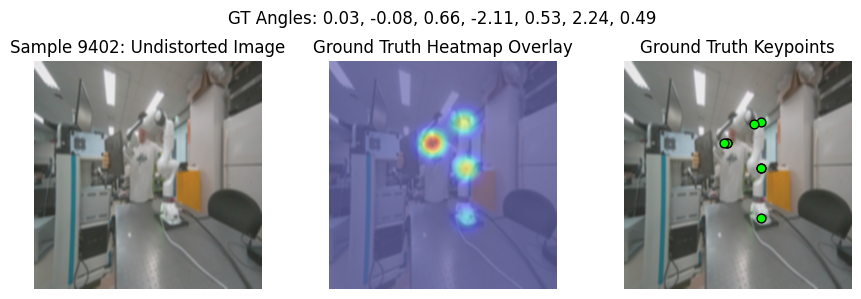

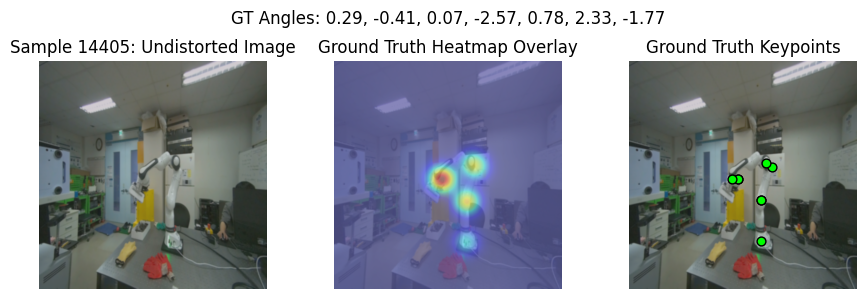

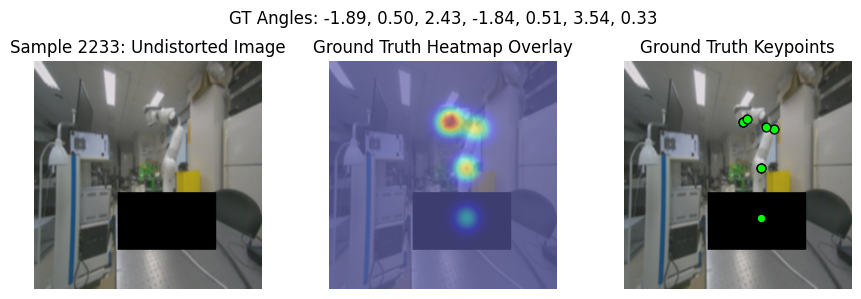


--- Starting Training ---


Epoch 1 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:51<00:00,  4.72s/it, loss_ang=0.0339, loss_kpt=0.011] 


Epoch 1/100 Summary -> Train Losses [Kpt: 0.014255, Ang: 0.038286], Avg Val Loss: 0.014238
Epoch 1/100 Summary -> Train Losses [Kpt: 0.014255, Ang: 0.038286], Avg Val Loss: 0.014238
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]
  -> üéâ New best model saved with validation loss: 0.014238

--- Visualizing Predictions for Epoch 1 ---


Epoch 2 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:35<00:00,  4.41s/it, loss_ang=0.0251, loss_kpt=0.0139]


Epoch 2/100 Summary -> Train Losses [Kpt: 0.013851, Ang: 0.035022], Avg Val Loss: 0.012784
Epoch 2/100 Summary -> Train Losses [Kpt: 0.013851, Ang: 0.035022], Avg Val Loss: 0.012784
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]
  -> üéâ New best model saved with validation loss: 0.012784

--- Visualizing Predictions for Epoch 2 ---


Epoch 3 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:37<00:00,  4.44s/it, loss_ang=0.039, loss_kpt=0.00969]


Epoch 3/100 Summary -> Train Losses [Kpt: 0.013224, Ang: 0.034395], Avg Val Loss: 0.011825
Epoch 3/100 Summary -> Train Losses [Kpt: 0.013224, Ang: 0.034395], Avg Val Loss: 0.011825
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]
  -> üéâ New best model saved with validation loss: 0.011825

--- Visualizing Predictions for Epoch 3 ---


Epoch 4 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:37<00:00,  4.44s/it, loss_ang=0.0433, loss_kpt=0.0138]


Epoch 4/100 Summary -> Train Losses [Kpt: 0.013277, Ang: 0.032712], Avg Val Loss: 0.012233
Epoch 4/100 Summary -> Train Losses [Kpt: 0.013277, Ang: 0.032712], Avg Val Loss: 0.012233
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]


Epoch 5 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0431, loss_kpt=0.0107]


Epoch 5/100 Summary -> Train Losses [Kpt: 0.013077, Ang: 0.035210], Avg Val Loss: 0.011292
Epoch 5/100 Summary -> Train Losses [Kpt: 0.013077, Ang: 0.035210], Avg Val Loss: 0.011292
  -> Current LRs [Kpt: 0.000099, Ang: 0.000099]
  -> üéâ New best model saved with validation loss: 0.011292

--- Visualizing Predictions for Epoch 5 ---


Epoch 6 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:36<00:00,  4.41s/it, loss_ang=0.016, loss_kpt=0.0084] 


Epoch 6/100 Summary -> Train Losses [Kpt: 0.012640, Ang: 0.033288], Avg Val Loss: 0.011252
Epoch 6/100 Summary -> Train Losses [Kpt: 0.012640, Ang: 0.033288], Avg Val Loss: 0.011252
  -> Current LRs [Kpt: 0.000099, Ang: 0.000099]
  -> üéâ New best model saved with validation loss: 0.011252

--- Visualizing Predictions for Epoch 6 ---


Epoch 7 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:36<00:00,  4.42s/it, loss_ang=0.0341, loss_kpt=0.0124]


Epoch 7/100 Summary -> Train Losses [Kpt: 0.012578, Ang: 0.032936], Avg Val Loss: 0.011605
Epoch 7/100 Summary -> Train Losses [Kpt: 0.012578, Ang: 0.032936], Avg Val Loss: 0.011605
  -> Current LRs [Kpt: 0.000099, Ang: 0.000099]


Epoch 8 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:33<00:00,  4.36s/it, loss_ang=0.0304, loss_kpt=0.0136] 


Epoch 8/100 Summary -> Train Losses [Kpt: 0.012406, Ang: 0.031890], Avg Val Loss: 0.010898
Epoch 8/100 Summary -> Train Losses [Kpt: 0.012406, Ang: 0.031890], Avg Val Loss: 0.010898
  -> Current LRs [Kpt: 0.000098, Ang: 0.000098]
  -> üéâ New best model saved with validation loss: 0.010898

--- Visualizing Predictions for Epoch 8 ---


Epoch 9 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0452, loss_kpt=0.0189] 


Epoch 9/100 Summary -> Train Losses [Kpt: 0.012131, Ang: 0.031899], Avg Val Loss: 0.011044
Epoch 9/100 Summary -> Train Losses [Kpt: 0.012131, Ang: 0.031899], Avg Val Loss: 0.011044
  -> Current LRs [Kpt: 0.000098, Ang: 0.000098]


Epoch 10 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:35<00:00,  4.40s/it, loss_ang=0.0291, loss_kpt=0.0114] 


Epoch 10/100 Summary -> Train Losses [Kpt: 0.011969, Ang: 0.031235], Avg Val Loss: 0.011339
Epoch 10/100 Summary -> Train Losses [Kpt: 0.011969, Ang: 0.031235], Avg Val Loss: 0.011339
  -> Current LRs [Kpt: 0.000098, Ang: 0.000098]


Epoch 11 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:33<00:00,  4.36s/it, loss_ang=0.0213, loss_kpt=0.0114] 


Epoch 11/100 Summary -> Train Losses [Kpt: 0.011414, Ang: 0.029838], Avg Val Loss: 0.010947
Epoch 11/100 Summary -> Train Losses [Kpt: 0.011414, Ang: 0.029838], Avg Val Loss: 0.010947
  -> Current LRs [Kpt: 0.000097, Ang: 0.000097]


Epoch 12 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0499, loss_kpt=0.016]  


Epoch 12/100 Summary -> Train Losses [Kpt: 0.012072, Ang: 0.032821], Avg Val Loss: 0.011184
Epoch 12/100 Summary -> Train Losses [Kpt: 0.012072, Ang: 0.032821], Avg Val Loss: 0.011184
  -> Current LRs [Kpt: 0.000097, Ang: 0.000097]


Epoch 13 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:29<00:00,  4.27s/it, loss_ang=0.0368, loss_kpt=0.0126] 


Epoch 13/100 Summary -> Train Losses [Kpt: 0.011579, Ang: 0.029943], Avg Val Loss: 0.010468
Epoch 13/100 Summary -> Train Losses [Kpt: 0.011579, Ang: 0.029943], Avg Val Loss: 0.010468
  -> Current LRs [Kpt: 0.000096, Ang: 0.000096]
  -> üéâ New best model saved with validation loss: 0.010468

--- Visualizing Predictions for Epoch 13 ---


Epoch 14 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:35<00:00,  4.39s/it, loss_ang=0.0241, loss_kpt=0.0119] 


Epoch 14/100 Summary -> Train Losses [Kpt: 0.012083, Ang: 0.028891], Avg Val Loss: 0.010609
Epoch 14/100 Summary -> Train Losses [Kpt: 0.012083, Ang: 0.028891], Avg Val Loss: 0.010609
  -> Current LRs [Kpt: 0.000095, Ang: 0.000095]


Epoch 15 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:35<00:00,  4.40s/it, loss_ang=0.0158, loss_kpt=0.0074] 


Epoch 15/100 Summary -> Train Losses [Kpt: 0.011500, Ang: 0.028536], Avg Val Loss: 0.011140
Epoch 15/100 Summary -> Train Losses [Kpt: 0.011500, Ang: 0.028536], Avg Val Loss: 0.011140
  -> Current LRs [Kpt: 0.000095, Ang: 0.000095]


Epoch 16 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0166, loss_kpt=0.0107] 


Epoch 16/100 Summary -> Train Losses [Kpt: 0.011062, Ang: 0.026698], Avg Val Loss: 0.010839
Epoch 16/100 Summary -> Train Losses [Kpt: 0.011062, Ang: 0.026698], Avg Val Loss: 0.010839
  -> Current LRs [Kpt: 0.000094, Ang: 0.000094]


Epoch 17 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:34<00:00,  4.38s/it, loss_ang=0.0306, loss_kpt=0.017]  


Epoch 17/100 Summary -> Train Losses [Kpt: 0.011239, Ang: 0.028136], Avg Val Loss: 0.010417
Epoch 17/100 Summary -> Train Losses [Kpt: 0.011239, Ang: 0.028136], Avg Val Loss: 0.010417
  -> Current LRs [Kpt: 0.000093, Ang: 0.000093]
  -> üéâ New best model saved with validation loss: 0.010417

--- Visualizing Predictions for Epoch 17 ---


Epoch 18 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:34<00:00,  4.39s/it, loss_ang=0.0415, loss_kpt=0.0133] 


Epoch 18/100 Summary -> Train Losses [Kpt: 0.010984, Ang: 0.026852], Avg Val Loss: 0.010849
Epoch 18/100 Summary -> Train Losses [Kpt: 0.010984, Ang: 0.026852], Avg Val Loss: 0.010849
  -> Current LRs [Kpt: 0.000092, Ang: 0.000092]


Epoch 19 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:32<00:00,  4.33s/it, loss_ang=0.0225, loss_kpt=0.00795]


Epoch 19/100 Summary -> Train Losses [Kpt: 0.010999, Ang: 0.027063], Avg Val Loss: 0.010387
Epoch 19/100 Summary -> Train Losses [Kpt: 0.010999, Ang: 0.027063], Avg Val Loss: 0.010387
  -> Current LRs [Kpt: 0.000091, Ang: 0.000091]
  -> üéâ New best model saved with validation loss: 0.010387

--- Visualizing Predictions for Epoch 19 ---


Epoch 20 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:30<00:00,  4.30s/it, loss_ang=0.0159, loss_kpt=0.015]  


Epoch 20/100 Summary -> Train Losses [Kpt: 0.011489, Ang: 0.026668], Avg Val Loss: 0.010473
Epoch 20/100 Summary -> Train Losses [Kpt: 0.011489, Ang: 0.026668], Avg Val Loss: 0.010473
  -> Current LRs [Kpt: 0.000091, Ang: 0.000091]


Epoch 21 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:33<00:00,  4.37s/it, loss_ang=0.0154, loss_kpt=0.00985]


Epoch 21/100 Summary -> Train Losses [Kpt: 0.010764, Ang: 0.026595], Avg Val Loss: 0.010068
Epoch 21/100 Summary -> Train Losses [Kpt: 0.010764, Ang: 0.026595], Avg Val Loss: 0.010068
  -> Current LRs [Kpt: 0.000090, Ang: 0.000090]
  -> üéâ New best model saved with validation loss: 0.010068

--- Visualizing Predictions for Epoch 21 ---


/tmp/ipykernel_1063553/58160635.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 4, figsize=(18, 5)) # ‚úÖ figsizeÎèÑ Ï†ÅÏ†àÌïòÍ≤å Ï°∞Ï†ï
Epoch 22 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:35<00:00,  4.41s/it, loss_ang=0.0179, loss_kpt=0.00622]


Epoch 22/100 Summary -> Train Losses [Kpt: 0.010844, Ang: 0.026319], Avg Val Loss: 0.010276
Epoch 22/100 Summary -> Train Losses [Kpt: 0.010844, Ang: 0.026319], Avg Val Loss: 0.010276
  -> Current LRs [Kpt: 0.000089, Ang: 0.000089]


Epoch 23 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:34<00:00,  4.38s/it, loss_ang=0.0248, loss_kpt=0.00956]


Epoch 23/100 Summary -> Train Losses [Kpt: 0.010189, Ang: 0.024950], Avg Val Loss: 0.009658
Epoch 23/100 Summary -> Train Losses [Kpt: 0.010189, Ang: 0.024950], Avg Val Loss: 0.009658
  -> Current LRs [Kpt: 0.000088, Ang: 0.000088]
  -> üéâ New best model saved with validation loss: 0.009658

--- Visualizing Predictions for Epoch 23 ---


Epoch 24 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:35<00:00,  4.39s/it, loss_ang=0.0315, loss_kpt=0.0107] 


Epoch 24/100 Summary -> Train Losses [Kpt: 0.010629, Ang: 0.026167], Avg Val Loss: 0.010299
Epoch 24/100 Summary -> Train Losses [Kpt: 0.010629, Ang: 0.026167], Avg Val Loss: 0.010299
  -> Current LRs [Kpt: 0.000087, Ang: 0.000087]


Epoch 25 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0283, loss_kpt=0.0133] 


Epoch 25/100 Summary -> Train Losses [Kpt: 0.010542, Ang: 0.027811], Avg Val Loss: 0.010157
Epoch 25/100 Summary -> Train Losses [Kpt: 0.010542, Ang: 0.027811], Avg Val Loss: 0.010157
  -> Current LRs [Kpt: 0.000086, Ang: 0.000086]


Epoch 26 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:31<00:00,  4.31s/it, loss_ang=0.0217, loss_kpt=0.00879]


Epoch 26/100 Summary -> Train Losses [Kpt: 0.010715, Ang: 0.026115], Avg Val Loss: 0.009643
Epoch 26/100 Summary -> Train Losses [Kpt: 0.010715, Ang: 0.026115], Avg Val Loss: 0.009643
  -> Current LRs [Kpt: 0.000084, Ang: 0.000084]
  -> üéâ New best model saved with validation loss: 0.009643

--- Visualizing Predictions for Epoch 26 ---


Epoch 27 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:30<00:00,  4.30s/it, loss_ang=0.0323, loss_kpt=0.0203] 


Epoch 27/100 Summary -> Train Losses [Kpt: 0.010166, Ang: 0.024455], Avg Val Loss: 0.009880
Epoch 27/100 Summary -> Train Losses [Kpt: 0.010166, Ang: 0.024455], Avg Val Loss: 0.009880
  -> Current LRs [Kpt: 0.000083, Ang: 0.000083]


Epoch 28 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:34<00:00,  4.37s/it, loss_ang=0.0338, loss_kpt=0.00851]


Epoch 28/100 Summary -> Train Losses [Kpt: 0.010298, Ang: 0.025685], Avg Val Loss: 0.010407
Epoch 28/100 Summary -> Train Losses [Kpt: 0.010298, Ang: 0.025685], Avg Val Loss: 0.010407
  -> Current LRs [Kpt: 0.000082, Ang: 0.000082]


Epoch 29 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:38<00:00,  4.46s/it, loss_ang=0.0169, loss_kpt=0.00923]


Epoch 29/100 Summary -> Train Losses [Kpt: 0.010316, Ang: 0.023379], Avg Val Loss: 0.009597
Epoch 29/100 Summary -> Train Losses [Kpt: 0.010316, Ang: 0.023379], Avg Val Loss: 0.009597
  -> Current LRs [Kpt: 0.000081, Ang: 0.000081]
  -> üéâ New best model saved with validation loss: 0.009597

--- Visualizing Predictions for Epoch 29 ---


Epoch 30 [Train]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49/49 [03:38<00:00,  4.45s/it, loss_ang=0.0482, loss_kpt=0.019]  


Epoch 30/100 Summary -> Train Losses [Kpt: 0.010562, Ang: 0.025367], Avg Val Loss: 0.009104
Epoch 30/100 Summary -> Train Losses [Kpt: 0.010562, Ang: 0.025367], Avg Val Loss: 0.009104
  -> Current LRs [Kpt: 0.000080, Ang: 0.000080]
  -> üéâ New best model saved with validation loss: 0.009104

--- Visualizing Predictions for Epoch 30 ---


Epoch 31 [Train]:  14%|‚ñà‚ñç        | 7/49 [01:25<08:32, 12.21s/it, loss_ang=0.0241, loss_kpt=0.0138] 
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.


KeyboardInterrupt: 

socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.s

In [ ]:
# ==============================================================================
# 3. ÌïôÏäµ Î∞è Í≤ÄÏ¶ù Î£®ÌîÑ (Training & Validation Loop) = v2 version
# ==============================================================================
def setup(hyperparameters, dataset_pairs):
    """ÌïôÏäµÏóê ÌïÑÏöîÌïú Î™®Îì† Íµ¨ÏÑ± ÏöîÏÜåÎ•º Ï§ÄÎπÑÌï©ÎãàÎã§. (CPU Transform Î≤ÑÏ†Ñ)"""
    print("--- Setting up the environment ---")
    
    # --- 1. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Î∞è Ïû•Ïπò ÏÑ§Ï†ï ---
    model_name = hyperparameters['model_name']
    batch_size = hyperparameters['batch_size']
    val_split = hyperparameters['val_split']
    num_epochs = hyperparameters['num_epochs']
    lr_kpt = hyperparameters['lr_kpt']
    lr_ang = hyperparameters['lr_ang']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # --- 2. Transform Ï†ïÏùò (CPU Í∏∞Î∞òÏúºÎ°ú ÌÜµÌï©) ---
    dino_model_for_config = timm.create_model(model_name, pretrained=True)
    config = dino_model_for_config.default_cfg
    
    # ‚úÖ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïö© Transform (Ï¶ùÍ∞ï Ìè¨Ìï®)
    train_transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ColorJitter(brightness=0.2, contrast=0.15, saturation=0.15, hue=0.05),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.2, scale=(0.1, 0.2), ratio=(0.3, 2.0)),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])

    # ‚úÖ Í≤ÄÏ¶ù Î∞è ÏãúÍ∞ÅÌôîÏö© Transform (Ï¶ùÍ∞ï ÏóÜÏùå)
    val_transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])
    
    print("CPU-based transforms created for training and validation.")

    # --- 3. Dataset Î∞è DataLoader Ï§ÄÎπÑ ---
    indices = torch.randperm(len(dataset_pairs)).tolist()
    train_size = int(len(dataset_pairs) * (1 - val_split))
    train_pairs = [dataset_pairs[i] for i in indices[:train_size]]
    val_pairs = [dataset_pairs[i] for i in indices[train_size:]]
    
    # ‚úÖ Í∞Å Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎßûÎäî transform Ï†ÑÎã¨
    train_dataset = RobotPoseDataset(pairs=train_pairs, transform=train_transform)
    val_dataset = RobotPoseDataset(pairs=val_pairs, transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=24, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True, persistent_workers=True)
    print(f"Dataset split: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")


    # ‚úÖ --- 4. Î™®Îç∏, ÏÜêÏã§ Ìï®Ïàò, ÏòµÌã∞ÎßàÏù¥Ï†Ä, Ïä§ÏºÄÏ§ÑÎü¨ Ï§ÄÎπÑ (ÎàÑÎùΩÎêú Î∂ÄÎ∂Ñ Ï∂îÍ∞Ä) ---
    # --------------------------------------------------------------------------
    model = DINOv2PoseEstimator(model_name)

    # DINOv2 Î∞±Î≥∏ ÎèôÍ≤∞
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    if torch.cuda.device_count() > 1:
        print(f"Let's use {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
        
    model.to(device)
        
    crit_kpt = nn.MSELoss()
    crit_ang = nn.SmoothL1Loss(beta=1.0)

    model_to_access = model.module if isinstance(model, nn.DataParallel) else model
    
    optimizer_kpt = torch.optim.AdamW(model_to_access.keypoint_head.parameters(), lr=lr_kpt)
    optimizer_ang = torch.optim.AdamW(model_to_access.angle_head.parameters(), lr=lr_ang)

    scheduler_kpt = CosineAnnealingLR(optimizer_kpt, T_max=num_epochs, eta_min=1e-6)
    scheduler_ang = CosineAnnealingLR(optimizer_ang, T_max=num_epochs, eta_min=1e-6)
    
    print(f"Model, losses, and optimizers are ready. Using device: {device}")
    
    return model, train_loader, val_loader, crit_kpt, crit_ang, \
           optimizer_kpt, optimizer_ang, scheduler_kpt, scheduler_ang, \
           device, config, val_transform # vis_transform ÎåÄÏã† val_transform Î∞òÌôò
    # --------------------------------------------------------------------------
# ==============================================================================
# 4. Î©îÏù∏ Ïã§ÌñâÎ∂Ä (Main Execution)
# ==============================================================================
import time

if __name__ == '__main__':
    
    hyperparameters = {
        'model_name': 'vit_base_patch14_dinov2.lvd142m',
        'batch_size': 300,
        'num_epochs': 100,
        'val_split': 0.1,
        'loss_weight_kpt': 100.0, # FocalLossÎ•º ÏÇ¨Ïö©ÌïòÎØÄÎ°ú 10Î°ú ÎêòÎèåÎ¶¨Í±∞ÎÇò Ï°∞Ï†à
        'lr_kpt': 0.0001,
        'lr_ang': 0.0001,
    }
    CHECKPOINT_PATH = '/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/model/checkpoint.pth'
    PRETRAINED_MODEL_PATH = 'best_pose_estimator_model.pth' 
    
    run = wandb.init(
        project="robot-pose-estimation", # wandb ÌîÑÎ°úÏ†ùÌä∏ Ïù¥Î¶Ñ
        config=hyperparameters,          # ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•
        name=f"run_{time.strftime('%Y%m%d_%H%M%S')}" # Ïã§Ìñâ Ïù¥Î¶Ñ (ÏÑ†ÌÉù ÏÇ¨Ìï≠)
    )
    
    # --------------------------------------------------------------------------
    # hyperparameters ÎîïÏÖîÎÑàÎ¶¨ Ï†ÑÏ≤¥ÏôÄ dataset_pairsÎßå Ï†ÑÎã¨Ìï©ÎãàÎã§.
    model, train_loader, val_loader, crit_kpt, crit_ang, \
    optimizer_kpt, optimizer_ang, scheduler_kpt, scheduler_ang, \
    device, config, vis_transform = setup(
        hyperparameters, dataset_pairs
    )
    # --------------------------------------------------------------------------
    
    wandb.watch(model, log="all", log_freq=100)
    
    start_epoch = 0
    best_val_loss = float('inf')

    if os.path.exists(PRETRAINED_MODEL_PATH):
        print(f"‚úÖ Found checkpoint at '{PRETRAINED_MODEL_PATH}'. Resuming training.")
        # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î°úÎìú (CPUÏóê Î®ºÏ†Ä Î°úÎìúÌïòÏó¨ Î©îÎ™®Î¶¨ Ïò§Î•ò Î∞©ÏßÄ)
        checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location='cpu')
        
        # DataParallel ÎûòÌïë Ïó¨Î∂ÄÏóê Îî∞Îùº state_dict Î°úÎìú
        model_to_load = model.module if isinstance(model, nn.DataParallel) else model
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model_to_load.load_state_dict(checkpoint['model_state_dict'])
        else:
            model_to_load.load_state_dict(checkpoint)
        
    else:
        print("‚ÑπÔ∏è No pretrained model found. Starting training from scratch.")
    # --------------------------------------------------------------------------

    visualize_dataset_sample(train_loader.dataset, config, num_samples=3)

    # --- ÌïôÏäµ ÏãúÏûë ---
    print("\n--- Starting Training ---")

    # ‚úÖ --- 2. ÌïôÏäµ Î£®ÌîÑ ÏãúÏûëÏ†ê ÏàòÏ†ï ---
    for epoch in range(start_epoch, hyperparameters['num_epochs']):
        train_loss_kpt, train_loss_ang = train_one_epoch(
            model, train_loader, optimizer_kpt, optimizer_ang, crit_kpt, crit_ang, device, loss_weight_kpt=hyperparameters['loss_weight_kpt'], epoch_num=epoch+1
        )
        val_loss = validate(model, val_loader, crit_kpt, crit_ang, device, loss_weight_kpt=hyperparameters['loss_weight_kpt'], epoch_num=epoch+1)
        
        print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']} Summary -> Train Losses [Kpt: {train_loss_kpt:.6f}, Ang: {train_loss_ang:.6f}], Avg Val Loss: {val_loss:.6f}")
        
        # ‚úÖ --- 3. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû• Î°úÏßÅ ÏàòÏ†ï ---
        # --------------------------------------------------------------------------
        # ÌòÑÏû¨ ÏóêÌè≠Ïùò ÏÉÅÌÉúÎ•º Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î°ú Ï†ÄÏû• (Îß§ ÏóêÌè≠ÎßàÎã§ ÎçÆÏñ¥Ïì∞Í∏∞)
        state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': state_to_save,
            'optimizer_kpt_state_dict': optimizer_kpt.state_dict(),
            'optimizer_ang_state_dict': optimizer_ang.state_dict(),
            'best_val_loss': best_val_loss,
        }
        # ‚úÖ Î∞±Í∑∏ÎùºÏö¥Îìú Ïä§Î†àÎìúÏóêÏÑú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•
        save_thread = threading.Thread(target=torch.save, args=(checkpoint, CHECKPOINT_PATH))
        save_thread.start() # Ï†ÄÏû•ÏùÑ ÏãúÏûëÌïòÍ≥† Î∞îÎ°ú Îã§Ïùå ÏΩîÎìúÎ°ú ÎÑòÏñ¥Í∞ê
        
        scheduler_kpt.step()
        scheduler_ang.step()

        current_lr_kpt = optimizer_kpt.param_groups[0]['lr']
        current_lr_ang = optimizer_ang.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']} Summary -> Train Losses [Kpt: {train_loss_kpt:.6f}, Ang: {train_loss_ang:.6f}], Avg Val Loss: {val_loss:.6f}")
        print(f"  -> Current LRs [Kpt: {current_lr_kpt:.6f}, Ang: {current_lr_ang:.6f}]")
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss_kpt": train_loss_kpt,
            "train_loss_ang": train_loss_ang,
            "avg_val_loss": val_loss,
            "lr_kpt": current_lr_kpt,
            "lr_ang": current_lr_ang
        })

        # ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ÏùÄ Î≥ÑÎèÑÎ°ú Ï†ÄÏû•
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # ÏúÑÏóêÏÑú Ïù¥ÎØ∏ Ï†ÄÏû•ÌñàÏúºÎØÄÎ°ú, Ïó¨Í∏∞ÏÑúÎäî ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ÏùÑ Î≥µÏÇ¨Ìï¥ÏÑú Îî∞Î°ú Î≥¥Í¥Ä
            # torch.save(state_to_save, 'best_pose_estimator_model.pth')
            print(f"  -> üéâ New best model saved with validation loss: {best_val_loss:.6f}")
            best_model_save_thread = threading.Thread(target=torch.save, args=(state_to_save, 'best_pose_estimator_model.pth'))
            best_model_save_thread.start()
            
            prediction_fig = visualize_predictions(
                model, val_loader.dataset, device, config, epoch_num=epoch + 1, num_samples=3
            )
            wandb.log({"validation_predictions": wandb.Image(prediction_fig)})
            # visualize_predictions(model, val_loader.dataset, device, config, epoch_num=epoch + 1, num_samples=3)
            plt.close(prediction_fig) # Î©îÎ™®Î¶¨ ÎàÑÏàò Î∞©ÏßÄÎ•º ÏúÑÌï¥ figure Îã´Í∏∞
        # --------------------------------------------------------------------------

    if 'save_thread' in locals() and save_thread.is_alive():
        save_thread.join()
        
    if 'best_model_save_thread' in locals() and best_model_save_thread.is_alive():
        best_model_save_thread.join()
        
    print("\n--- Training Finished ---")
    print(f"üèÜ Best validation loss: {best_val_loss:.6f}")
    print("Model and checkpoint saved to 'best_pose_estimator_model.pth' and 'checkpoint.pth'")
    
    run.finish()

--- Loading model ---


/tmp/ipykernel_1125679/778280.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Model loaded and set to cuda in eval mode.
Loaded 8 calibration files.
Loaded 16 Aruco entries for both poses.

--- Processing image: zed_41182735_left_1756277570.520.jpg ---
Heatmap scores [0.55264205 0.72799283 0.72778344 0.72136223 0.7169227  0.7168473
 0.7180804  0.72152734]
Visualizing Keypoint Head predictions by confidence...
‚úÖ Camera Pose (PnP) Estimation Successful!

--- Processing image: zed_49429257_left_1756282403.573.jpg ---
Heatmap scores [0.53420115 0.53725386 0.53736347 0.73563623 0.72217214 0.6782368
 0.67739606 0.5980484 ]
Visualizing Keypoint Head predictions by confidence...
‚úÖ Camera Pose (PnP) Estimation Successful!

--- Processing image: zed_49429257_left_1756281300.347.jpg ---
Heatmap scores [0.73525524 0.73143995 0.7308279  0.7223797  0.72391814 0.7293634
 0.7297758  0.72126484]
Visualizing Keypoint Head predictions by confidence...
‚úÖ Camera Pose (PnP) Estimation Successful!

--- Processing image: zed_44377151_right_1756281731.506.jpg ---
Heatmap scores [0

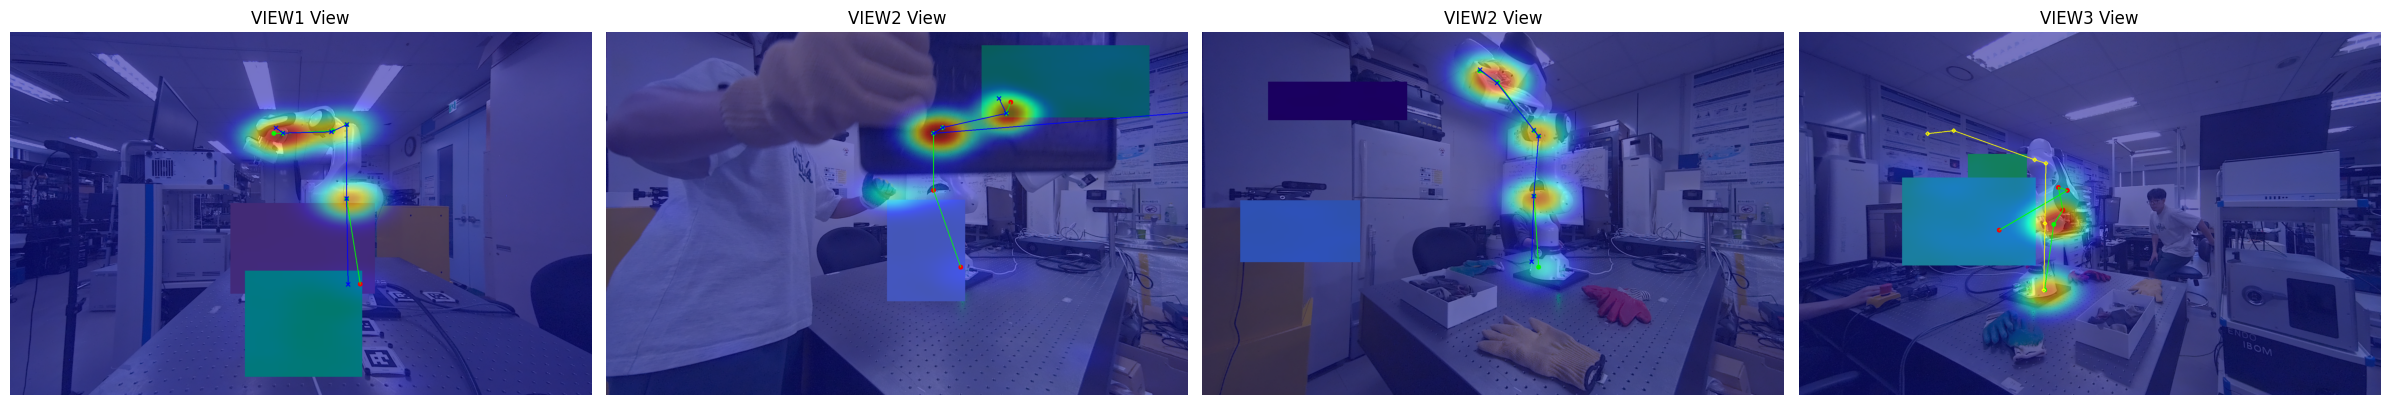

In [9]:
# ==============================================================================
# 1. Helper Ìï®Ïàò (Î™®Îç∏ Î°úÎî©, ÌÇ§Ìè¨Ïù∏Ìä∏ Ï∂îÏ∂ú, Ìè¨Ï¶à Ï∂îÏ†ï)
# ==============================================================================

def load_model(model_path, model_name, device):
    """ÌïôÏäµÎêú Î™®Îç∏ÏùÑ Î∂àÎü¨ÏôÄ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ïÌï©ÎãàÎã§."""
    print("--- Loading model ---")
    # DINOv2PoseEstimatorÍ∞Ä Ïò¨Î∞îÎ•∏ ÌÅ¥ÎûòÏä§ Ïù¥Î¶ÑÏù¥ÎùºÍ≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
    model = DINOv2PoseEstimator(model_name) 
    state_dict = torch.load(model_path, map_location=device)
    
    # DataParallelÎ°ú ÌïôÏäµÎêú Í≤ΩÏö∞ 'module.' Ï†ëÎëêÏÇ¨ Ï†úÍ±∞
    if next(iter(state_dict)).startswith('module.'):
        state_dict = {k[7:]: v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"Model loaded and set to {device} in eval mode.")
    return model

def extract_keypoints_from_heatmaps(heatmaps, original_image_size):
    """
    ÌûàÌä∏Îßµ ÌÖêÏÑúÏóêÏÑú 2D Ï¢åÌëúÏôÄ Í∞Å Ï¢åÌëúÏùò Ïã†Î¢∞ÎèÑ Ï†êÏàòÎ•º Ï∂îÏ∂úÌï©ÎãàÎã§.
    """
    num_joints, h, w = heatmaps.shape
    original_h, original_w = original_image_size
    keypoints = np.zeros((num_joints, 2), dtype=np.float32)
    scores = np.zeros(num_joints, dtype=np.float32) # Ïã†Î¢∞ÎèÑ Ï†êÏàòÎ•º Ï†ÄÏû•Ìï† Î∞∞Ïó¥ Ï∂îÍ∞Ä

    # Î™®Îç∏Ïùò raw Ï∂úÎ†•Ïù¥ÎØÄÎ°ú sigmoidÎ•º Ï†ÅÏö©ÌïòÏó¨ ÌôïÎ•†Ï≤òÎüº ÎßåÎì≠ÎãàÎã§.
    # ÎßåÏïΩ FocalLoss Îì±ÏóêÏÑú Ïù¥ÎØ∏ sigmoidÍ∞Ä Ï†ÅÏö©ÎêòÏóàÎã§Î©¥ Ïù¥ Î∂ÄÎ∂ÑÏùÄ ÏÉùÎûµ Í∞ÄÎä•Ìï©ÎãàÎã§.
    heatmaps = heatmaps.sigmoid()

    for i in range(num_joints):
        heatmap = heatmaps[i]
        
        # 1D ÌÖêÏÑúÎ°ú ÌéºÏ≥êÏÑú ÏµúÎåÄÍ∞íÍ≥º Í∑∏ Ïù∏Îç±Ïä§Î•º Ï∞æÏäµÎãàÎã§.
        flat_heatmap = heatmap.view(-1)
        max_val, max_idx = torch.max(flat_heatmap, dim=0)
        
        # ÏµúÎåÄÍ∞íÏùÑ Ïã†Î¢∞ÎèÑ Ï†êÏàòÎ°ú Ï†ÄÏû•
        scores[i] = max_val.item()
        
        # 1D Ïù∏Îç±Ïä§Î•º 2D (y, x) Ï¢åÌëúÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
        y, x = np.unravel_index(max_idx.cpu().numpy(), (h, w))
        
        # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Ï¢åÌëúÎ•º Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§.
        scaled_x = x * (original_w / w)
        scaled_y = y * (original_h / h)
        keypoints[i] = [scaled_x, scaled_y]
        
    return keypoints, scores # Ï¢åÌëúÏôÄ Ï†êÏàò Î™®Îëê Î∞òÌôò

def estimate_camera_pose(predicted_angles, predicted_heatmaps, camera_matrix, dist_coeffs, selected_view, original_image_size, confidence_threshold=0.1):
    """
    Î™®Îç∏ ÏòàÏ∏°ÏúºÎ°úÎ∂ÄÌÑ∞ FKÏôÄ PnPÎ•º ÌÜµÌï¥ Ïπ¥Î©îÎùº Ìè¨Ï¶à(Rvec, Tvec)Î•º Ï∂îÏ†ïÌï©ÎãàÎã§.
    Ïù¥Îïå, Ïã†Î¢∞ÎèÑÍ∞Ä ÎÇÆÏùÄ 2D ÌÇ§Ìè¨Ïù∏Ìä∏Îäî ÌïÑÌÑ∞ÎßÅÌï©ÎãàÎã§.
    """
    angles_np = predicted_angles.detach().cpu().numpy()
    object_points_3d = angle_to_joint_coordinate(angles_np, selected_view)
    
    # 2. ÌûàÌä∏ÎßµÏóêÏÑú 2D Ï¢åÌëúÏôÄ Ïã†Î¢∞ÎèÑ Ï†êÏàò Ï∂îÏ∂ú
    image_points_2d, scores = extract_keypoints_from_heatmaps(predicted_heatmaps, original_image_size)
    print(f'Heatmap scores {scores}')
    # ‚úÖ Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ: Ïã†Î¢∞ÎèÑ Í∏∞Î∞ò ÌïÑÌÑ∞ÎßÅ
    # ----------------------------------------------------------------------
    # Ïã†Î¢∞ÎèÑ Ï†êÏàòÍ∞Ä ÏûÑÍ≥ÑÍ∞í Ïù¥ÏÉÅÏù∏ Ï†êÎì§Ïùò Ïù∏Îç±Ïä§Î•º Ï∞æÏäµÎãàÎã§.
    high_conf_indices = np.where(scores >= confidence_threshold)[0]
    
    # Ìï¥Îãπ Ïù∏Îç±Ïä§Î•º ÏÇ¨Ïö©ÌïòÏó¨ 3D Ï†êÍ≥º 2D Ï†êÏùÑ ÌïÑÌÑ∞ÎßÅÌï©ÎãàÎã§.
    filtered_object_points_3d = object_points_3d[high_conf_indices]
    filtered_image_points_2d = image_points_2d[high_conf_indices]
    
    # PnPÎ•º Ïã§ÌñâÌïòÍ∏∞Ïóê Ï†êÏù¥ Ï∂©Î∂ÑÌïúÏßÄ(ÏµúÏÜå 4Í∞ú) ÌôïÏù∏Ìï©ÎãàÎã§.
    if len(filtered_image_points_2d) < 4:
        print(f"  -> PnP Failed for '{selected_view}': Not enough high-confidence points found ({len(filtered_image_points_2d)} < 4).")
        return None, None, object_points_3d, image_points_2d # Ïã§Ìå®ÌïòÎçîÎùºÎèÑ Ï†ÑÏ≤¥ Ï†êÏùÄ ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ Î∞òÌôò
    # ----------------------------------------------------------------------

    try:
        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            filtered_object_points_3d, 
            filtered_image_points_2d, 
            camera_matrix, 
            dist_coeffs, 
            flags=cv2.SOLVEPNP_EPNP
        )
        
        num_inliers = len(inliers) if inliers is not None else 0
        if success and num_inliers >= 4:
            # ‚úÖ --- Ï∂îÍ∞Ä: Î¨ºÎ¶¨Ï†Å ÌÉÄÎãπÏÑ± Í≤ÄÏÇ¨ (Í±∞Î¶¨ Í∏∞Î∞ò) ---
            # tvecÏùò L2 normÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ Ïπ¥Î©îÎùºÏôÄ Î°úÎ¥á Î≤†Ïù¥Ïä§ ÏÇ¨Ïù¥Ïùò Í±∞Î¶¨Î•º Íµ¨Ìï©ÎãàÎã§.
            distance = np.linalg.norm(tvec)
            
            # Í±∞Î¶¨Í∞Ä Î¨ºÎ¶¨Ï†ÅÏúºÎ°ú ÌÉÄÎãπÌïú Î≤îÏúÑ ÎÇ¥Ïóê ÏûàÎäîÏßÄ ÌôïÏù∏Ìï©ÎãàÎã§.
            # Ïù¥ Î≤îÏúÑ(0.5m ~ 5.0m)Îäî Ïã§Ï†ú ÌôòÍ≤ΩÏóê ÎßûÍ≤å Ï°∞Ï†àÌï¥Ïïº Ìï©ÎãàÎã§.
            if 0.5 < distance < 5.0:
                # ÏÑ±Í≥µ ÏãúÏóêÎäî Ï†ÑÏ≤¥ Ï†êÎì§ÏùÑ Î∞òÌôòÌïòÏó¨ Ïû¨Ìà¨ÏòÅ ÏãúÍ∞ÅÌôîÏóê ÏÇ¨Ïö©
                return rvec, tvec, object_points_3d, image_points_2d
            else:
                # Í±∞Î¶¨Í∞Ä Î≤îÏúÑÎ•º Î≤óÏñ¥ÎÇòÎ©¥ PnPÍ∞Ä ÏÑ±Í≥µÌñàÎçîÎùºÎèÑ Ïã§Ìå®Î°ú Ï≤òÎ¶¨Ìï©ÎãàÎã§.
                print(f"  -> PnP Rejected for '{selected_view}': Implausible distance ({distance:.2f}m).")
                return None, None, object_points_3d, image_points_2d
            # ‚úÖ --- ÌÉÄÎãπÏÑ± Í≤ÄÏÇ¨ ÎÅù ---
        else:
            print(f"  -> PnP Failed for '{selected_view}': Success={success}, Inliers={num_inliers}/{len(filtered_image_points_2d)}")
            return None, None, object_points_3d, image_points_2d
            
    except cv2.error as e:
        print(f"PnP calculation failed for view {selected_view}: {e}")
        return None, None, object_points_3d, image_points_2d

def draw_skeleton(image, keypoints, links, color=(0, 255, 0), thickness=2):
    """
    Ï£ºÏñ¥ÏßÑ ÌÇ§Ìè¨Ïù∏Ìä∏Îì§ÏùÑ links Ï†ïÎ≥¥Ïóê Îî∞Îùº ÏÑ†ÏúºÎ°ú Ïó∞Í≤∞Ìï©ÎãàÎã§.
    Ïù¥Îïå, NaN Í∞íÏùÑ Í∞ÄÏßÑ ÌÇ§Ìè¨Ïù∏Ìä∏Îäî Ïó∞Í≤∞ÏóêÏÑú Ï†úÏô∏Ìï©ÎãàÎã§.
    """
    if keypoints is None or len(keypoints) == 0:
        return image
        
    for start_idx, end_idx in links:
        # ÌÇ§Ìè¨Ïù∏Ìä∏ Ïù∏Îç±Ïä§Í∞Ä Ïú†Ìö®Ìïú Î≤îÏúÑ ÎÇ¥Ïóê ÏûàÎäîÏßÄ ÌôïÏù∏
        if start_idx < len(keypoints) and end_idx < len(keypoints):
            
            start_kp = keypoints[start_idx]
            end_kp = keypoints[end_idx]
            
            # ‚úÖ Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ: Îëê Ï†êÏù¥ Î™®Îëê Ïú†Ìö®ÌïúÏßÄ(NaNÏù¥ ÏïÑÎãåÏßÄ) ÌôïÏù∏
            # ------------------------------------------------------------------
            if not np.isnan(start_kp).any() and not np.isnan(end_kp).any():
                # Îëê Ï†êÏù¥ Î™®Îëê Ïú†Ìö®Ìï† ÎïåÎßå ÏÑ†ÏùÑ Í∑∏Î¶ΩÎãàÎã§.
                start_point = tuple(map(int, start_kp.flatten()))
                end_point = tuple(map(int, end_kp.flatten()))
                cv2.line(image, start_point, end_point, color, thickness)
            # ------------------------------------------------------------------

    return image

def overlay_heatmap(image_np, heatmap_tensor, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê ÌûàÌä∏ÎßµÏùÑ Ïò§Î≤ÑÎ†àÏù¥ÌïòÏó¨ Î∞òÌôòÌï©ÎãàÎã§.
    """
    # ‚úÖ ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ: .numpy() Ìò∏Ï∂ú Ï†ÑÏóê .detach() Ï∂îÍ∞Ä
    # ----------------------------------------------------------------------
    heatmap_np = heatmap_tensor.detach().cpu().numpy()
    # ----------------------------------------------------------------------
    
    heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)
    heatmap_np = (heatmap_np * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(heatmap_np, colormap)
    heatmap_colored = cv2.resize(heatmap_colored, (image_np.shape[1], image_np.shape[0]))

    overlaid_image = cv2.addWeighted(image_np, 1 - alpha, heatmap_colored, alpha, 0)
    return overlaid_image

def load_image_and_preprocess(image_path, transform, camera_matrix, dist_coeffs, add_random_mask=False, mask_size_ratio=(0.1, 0.3), num_masks=1):
    """
    Ïù¥ÎØ∏ÏßÄÎ•º Î∂àÎü¨ÏôÄ ÏôúÍ≥° Î≥¥Ï†ïÏùÑ ÏàòÌñâÌïú Îí§, ÏõêÎ≥∏(ÏãúÍ∞ÅÌôîÏö©)Í≥º 
    Ï†ÑÏ≤òÎ¶¨Îêú ÌÖêÏÑú(Î™®Îç∏ ÏûÖÎ†•Ïö©)Î•º Î∞òÌôòÌï©ÎãàÎã§.
    """
    # 1. Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è ÏôúÍ≥° Î≥¥Ï†ï
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    undistorted_image_np = cv2.undistort(image_np, camera_matrix, dist_coeffs)
    
    # 2. Î™®Îç∏ ÏûÖÎ†• Î∞è ÏãúÍ∞ÅÌôîÏö©ÏúºÎ°ú ÏÇ¨Ïö©Ìï† Ïù¥ÎØ∏ÏßÄÏùò Í∏∞Î∞òÏùÑ undistorted Î≤ÑÏ†ÑÏúºÎ°ú ÏÑ§Ï†ï
    image_to_process_np = undistorted_image_np.copy()

    # 3. (ÏÑ†ÌÉù ÏÇ¨Ìï≠) ÎßàÏä§ÌÇπ Î°úÏßÅ Ï†ÅÏö©
    if add_random_mask:
        h, w, _ = image_to_process_np.shape
        for _ in range(num_masks):
            mask_w = int(w * random.uniform(mask_size_ratio[0], mask_size_ratio[1]))
            mask_h = int(h * random.uniform(mask_size_ratio[0], mask_size_ratio[1]))
            x_start = random.randint(0, w - mask_w)
            y_start = random.randint(0, h - mask_h)
            image_to_process_np[y_start:y_start+mask_h, x_start:x_start+mask_w] = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    
    # ‚úÖ --- 4. (ÏàòÏ†ï) ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú Ï≤òÎ¶¨Îêú Ïù¥ÎØ∏ÏßÄÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏãúÍ∞ÅÌôîÏö© Î∞è Î™®Îç∏ ÏûÖÎ†•Ïö© Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ± ---
    # Ïù¥Ï†ú ÎßàÏä§ÌÇπÏù¥ Ï†ÅÏö©Îêú image_to_process_npÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    visualization_image_np = cv2.cvtColor(image_to_process_np, cv2.COLOR_RGB2BGR)
    
    # Î™®Îç∏ ÏûÖÎ†•Ïö© ÌÖêÏÑú ÏÉùÏÑ±
    image_for_transform_pil = Image.fromarray(image_to_process_np)
    image_tensor = transform(image_for_transform_pil)
        
    return image_tensor, visualization_image_np

# ==============================================================================
# 2. Î©îÏù∏ Ïã§ÌñâÎ∂Ä (Jupyter NotebookÏö©)
# ==============================================================================

if __name__ == '__main__':
    # --- ÏÑ§Ï†ï ---
    MODEL_PATH = 'best_pose_estimator_model.pth'
    MODEL_NAME = 'vit_base_patch14_dinov2.lvd142m'
    CALIB_DIR = "../dataset/franka_research3/Calib_cam_from_conf"
    CONFIDENCE_THRESHOLD = 0.6
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- 1. Í≥µÏú† Î¶¨ÏÜåÏä§ Ï§ÄÎπÑ ---
    model = load_model(MODEL_PATH, MODEL_NAME, device)

    # Î™®Îç∏ ÏÑ§Ï†ï(config) Î∂àÎü¨Ïò§Í∏∞ (timm Í∏∞Î∞ò)
    timm_model = timm.create_model(MODEL_NAME, pretrained=False)
    config = timm_model.default_cfg
        
    transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])

    # Î™®Îì† Ï∫òÎ¶¨Î∏åÎ†àÏù¥ÏÖò ÌååÏùº ÎØ∏Î¶¨ Î°úÎìú
    calib_data_all = {}
    for calib_path in glob.glob(os.path.join(CALIB_DIR, "*.json")):
        filename = os.path.basename(calib_path).replace("_calib.json", "")
        with open(calib_path, 'r') as f:
            calib_data_all[filename] = json.load(f)
    print(f"Loaded {len(calib_data_all)} calibration files.")

    # ‚úÖ --- ÏàòÏ†ï: pose1Í≥º pose2Ïùò Aruco Îç∞Ïù¥ÌÑ∞Î•º ÌïòÎÇòÏùò Ï°∞Ìöå ÌÖåÏù¥Î∏îÎ°ú ÌÜµÌï© ---
    aruco_lookup = {}
    for pose_name in ['pose1', 'pose2']:
        aruco_path = f'../dataset/franka_research3/{pose_name}_aruco_pose_summary.json'
        with open(aruco_path, 'r') as f:
            aruco_data = json.load(f)
        for item in aruco_data:
            key = f"{pose_name}_{item['view']}_{item['cam']}" # 'pose1_view1_leftcam' ÌòïÏãù
            aruco_lookup[key] = item
    print(f"Loaded {len(aruco_lookup)} Aruco entries for both poses.")

    # --- 2. Ï∂îÎ°†Ìï† Ïù¥ÎØ∏ÏßÄ Î™©Î°ù ---
    image_paths = [
        '../dataset/franka_research3/franka_research3_pose1/Panda_dataset_5th/view1/zed_41182735_left_1756277570.520.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_22th_block/view2/zed_49429257_left_1756282403.573.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_16th_dark1_light1/view2/zed_49429257_left_1756281300.347.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_18th_dark2/view3/zed_44377151_right_1756281731.506.jpg'
    ]

    # ‚úÖ --- ÏàòÏ†ï: ÎàÑÎùΩÎêú ÏãúÎ¶¨Ïñº Î≤àÌò∏ Ï∂îÍ∞Ä ---
    serial_to_view = {
        '41182735': "view1", '49429257': "view2",
        '44377151': "view3", '49045152': "view4"
    }

    # ‚úÖ Í¥ÄÏ†à 8Í∞ú(0~7)Î•º Ïó∞Í≤∞ÌïòÎäî ÎßÅÌÅ¨. (0,1), (1,2), ..., (6,7)
    robot_links = [(i, i + 1) for i in range(7)] 

    # --- 3. Î©îÏù∏ Ï∂îÎ°† Î∞è Í≤∞Í≥º Ï†ÄÏû• Î£®ÌîÑ ---
    visualized_results = []
    
    for path in image_paths:
        if not os.path.exists(path):
            print(f"Image not found: {path}. Skipping.")
            continue
        
        print(f"\n--- Processing image: {os.path.basename(path)} ---")
        

        filename_parts = os.path.basename(path).split('_')
        serial_str, cam_type = filename_parts[1], filename_parts[2] + "cam"
        selected_view = serial_to_view.get(serial_str, "unknown")
        
        calib_key = f"{selected_view}_{serial_str}_{cam_type}"
        if calib_key not in calib_data_all:
            print(f"Calibration data not found for key: {calib_key}. Skipping.")
            continue
        calib = calib_data_all[calib_key]
        camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
        dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
        image_tensor, original_image = load_image_and_preprocess(path, transform, camera_matrix, dist_coeffs, add_random_mask=True, mask_size_ratio=(0.1, 0.3), num_masks=2)

        pred_heatmaps_batch, pred_angles_batch = model(image_tensor.unsqueeze(0).to(device))
        
        original_size = original_image.shape[:2]
        vis_image = original_image.copy() # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÎ•º Î≥µÏÇ¨ÌïòÏó¨ ÏÇ¨Ïö©
        
        # ‚úÖ ÌûàÌä∏Îßµ Ïò§Î≤ÑÎ†àÏù¥ Ï∂îÍ∞Ä
        # ----------------------------------------------------------------------
        # Î™®Îì† ÌÇ§Ìè¨Ïù∏Ìä∏ ÌûàÌä∏ÎßµÏùÑ Ìï©Ï≥êÏÑú ÌïòÎÇòÏùò ÌûàÌä∏ÎßµÏúºÎ°ú ÎßåÎì≠ÎãàÎã§.
        # `pred_heatmaps_batch`Ïùò ÌÅ¨Í∏∞Îäî (batch_size, num_joints, h, w)
        # Ïó¨Í∏∞ÏÑúÎäî Ï≤´ Î≤àÏß∏ ÏÉòÌîåÏùò Î™®Îì† Í¥ÄÏ†à ÌûàÌä∏ÎßµÏùÑ Ìï©Ïπ©ÎãàÎã§.
        summed_heatmap = torch.sum(pred_heatmaps_batch[0], dim=0) # (num_joints, h, w) -> (h, w)
        
        # Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê Ìï©Ï≥êÏßÑ ÌûàÌä∏ÎßµÏùÑ Ïò§Î≤ÑÎ†àÏù¥
        vis_image_with_heatmap = overlay_heatmap(vis_image, summed_heatmap, alpha=0.5)
        # Ïù¥Ï†úÎ∂ÄÌÑ∞ Î™®Îì† Í∑∏Î¶ºÏùÄ vis_image_with_heatmap ÏúÑÏóê Í∑∏Î¶ΩÎãàÎã§.
        vis_image = vis_image_with_heatmap
        # ----------------------------------------------------------------------

        # PnPÎ•º ÏãúÎèÑÌïòÍ≥† Í≤∞Í≥ºÎ•º Î∞õÏùå
        rvec, tvec, object_points_3d, image_points_2d = estimate_camera_pose(
            pred_angles_batch[0], pred_heatmaps_batch[0], camera_matrix, 
            dist_coeffs, selected_view, original_size,
            confidence_threshold=CONFIDENCE_THRESHOLD 
        )
        
        pose_name = 'pose1' if 'pose1' in path else 'pose2'
        
        # 2D ÌÇ§Ìè¨Ïù∏Ìä∏ Ïã†Î¢∞ÎèÑ Ï†êÏàòÎèÑ Îã§Ïãú Ï∂îÏ∂ú (ÏãúÍ∞ÅÌôîÏö©)
        _, scores = extract_keypoints_from_heatmaps(pred_heatmaps_batch[0], original_size)

        # Ïã†Î¢∞ÎèÑÏóê Îî∞Îùº KeypointHead ÏòàÏ∏° ÏãúÍ∞ÅÌôî (ÎÖπÏÉâ/Îπ®Í∞ÑÏÉâ Ïõê)
        # Ïù¥Ï†úÎäî Ï†êÏùò ÏÉâÏÉÅÏùÑ Î∞îÍøîÏÑú ÌûàÌä∏Îßµ ÏúÑÏóê Î™ÖÌôïÌûà Î≥¥Ïù¥ÎèÑÎ°ù Ìï©ÎãàÎã§.
        print("Visualizing Keypoint Head predictions by confidence...")
        # high_conf_points = [] # Ïù¥Ï†ú Ïù¥ Î¶¨Ïä§Ìä∏Îäî ÌïÑÏöî ÏóÜÏäµÎãàÎã§.
        for i, pt in enumerate(image_points_2d):
            score = scores[i]
            center = tuple(map(int, pt.flatten()))
            if score >= CONFIDENCE_THRESHOLD:
                cv2.circle(vis_image, center, 8, (0, 255, 0), -1) # ÎÖπÏÉâ Ïõê
            else:
                cv2.circle(vis_image, center, 8, (0, 0, 255), -1) # Îπ®Í∞ÑÏÉâ Ïõê (ÎÇÆÏùÄ Ïã†Î¢∞ÎèÑ)

        # KeypointHead ÏòàÏ∏° Ïä§ÏºàÎ†àÌÜ§ Í∑∏Î¶¨Í∏∞ (Ïã†Î¢∞ÎèÑ ÎÜíÏùÄ Ï†êÎì§Îßå Ïó∞Í≤∞)
        visible_keypoints = np.full((len(image_points_2d), 2), np.nan, dtype=np.float32)
        high_conf_indices = np.where(scores >= CONFIDENCE_THRESHOLD)[0]
        visible_keypoints[high_conf_indices] = image_points_2d[high_conf_indices]
        # Ïä§ÏºàÎ†àÌÜ§ÏùÄ Ïó¨Ï†ÑÌûà Î™®Îì† ÌÇ§Ìè¨Ïù∏Ìä∏ Ï†ïÎ≥¥ (visible_keypoints)Î•º Í∏∞Î∞òÏúºÎ°ú Í∑∏Î¶¨Îêò,
        # Ïú†Ìö®Ìïú Ï†êÎì§Îßå Ïó∞Í≤∞ÎêòÎèÑÎ°ù draw_skeleton ÎÇ¥Î∂Ä Î°úÏßÅÏù¥ Ï≤òÎ¶¨Ìï©ÎãàÎã§.
        draw_skeleton(vis_image, image_points_2d, robot_links, color=(0, 255, 0), thickness=2) # ÎÖπÏÉâ ÏÑ†

        # PnP ÏÑ±Í≥µ/Ïã§Ìå®Ïóê Îî∞Î•∏ ÏãúÍ∞ÅÌôî
        if rvec is not None:
            print("‚úÖ Camera Pose (PnP) Estimation Successful!")
            reprojected_points, _ = cv2.projectPoints(object_points_3d, rvec, tvec, camera_matrix, dist_coeffs)
            reprojected_points = reprojected_points.reshape(-1, 2)
            
            # ‚úÖ --- Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ: Ïú†Ìö®ÌïòÏßÄ ÏïäÏùÄ Ï¢åÌëú ÌïÑÌÑ∞ÎßÅ ---
            # np.isfinite()Î•º ÏÇ¨Ïö©ÌïòÏó¨ NaNÏù¥ÎÇò Î¨¥ÌïúÎåÄ Í∞íÏù¥ Ìè¨Ìï®Îêú Ï†êÏùÑ Í±∏Îü¨ÎÉÖÎãàÎã§.
            # .all(axis=1)Îäî (x, y) Ï¢åÌëú Îëò Îã§ Ïú†Ìö®Ìïú Í≤ΩÏö∞ÏóêÎßå TrueÎ•º Î∞òÌôòÌï©ÎãàÎã§.
            valid_points_mask = np.isfinite(reprojected_points).all(axis=1)
            valid_reprojected_points = reprojected_points[valid_points_mask]
            
            # Ïú†Ìö®Ìïú Ï†êÎì§Îßå ÏÇ¨Ïö©ÌïòÏó¨ ÏãúÍ∞ÅÌôîÎ•º ÏßÑÌñâÌï©ÎãàÎã§.
            for pt in valid_reprojected_points:
                cv2.drawMarker(vis_image, tuple(map(int, pt.flatten())), (255, 0, 0), # ÌååÎûÄÏÉâ X
                            markerType=cv2.MARKER_TILTED_CROSS, markerSize=12, thickness=2)
                                
            # Ïû¨Ìà¨ÏòÅ Í≤∞Í≥º Ïä§ÏºàÎ†àÌÜ§ Í∑∏Î¶¨Í∏∞
            # draw_skeleton Ìï®ÏàòÎäî ÎÇ¥Î∂ÄÏóê NaN Ï≤¥ÌÅ¨ Î°úÏßÅÏù¥ ÏûàÏúºÎØÄÎ°ú, 
            # reprojected_pointsÎ•º Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©Ìï¥ÎèÑ ÏïàÏ†ÑÌï©ÎãàÎã§.
            draw_skeleton(vis_image, reprojected_points, robot_links, color=(255, 0, 0), thickness=2) # ÌååÎûÄÏÉâ ÏÑ†

        else:
            print("‚ùå Camera Pose (PnP) Estimation Failed.")
            print("  -> Visualizing Angle Head prediction based on initial Aruco pose.")
            
            # ‚úÖ --- ÏàòÏ†ï: Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°úÏóê ÎßûÎäî ÎèôÏ†Å Aruco ÌÇ§ ÏÉùÏÑ± ---
            aruco_key = f"{pose_name}_{selected_view}_{cam_type}"
            if aruco_key in aruco_lookup:
                aruco_result = aruco_lookup[aruco_key]
                angles_np = pred_angles_batch[0].detach().cpu().numpy()
                projected_3d_points = joint_coordinate_to_pixel_plane(
                    angle_to_joint_coordinate(angles_np, selected_view),
                    aruco_result, camera_matrix, dist_coeffs
                )
            for pt in projected_3d_points:
                cv2.drawMarker(vis_image, tuple(map(int, pt.flatten())), (0, 255, 255), # Ï≤≠Î°ùÏÉâ Îã§Ïù¥ÏïÑÎ™¨Îìú
                            markerType=cv2.MARKER_DIAMOND, markerSize=12, thickness=2)
                            
            # AngleHead ÏòàÏ∏° Í∏∞Î∞ò Ïä§ÏºàÎ†àÌÜ§ Í∑∏Î¶¨Í∏∞
            
            draw_skeleton(vis_image, projected_3d_points, robot_links, color=(0, 255, 255), thickness=2) # Ï≤≠Î°ùÏÉâ ÏÑ†
            
        visualized_results.append({'image': vis_image, 'title': f"{selected_view.upper()} View"})

    # --- 4. MatplotlibÏúºÎ°ú ÏµúÏ¢Ö Í≤∞Í≥º ÏãúÍ∞ÅÌôî ---
    num_images = len(visualized_results)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
    if num_images == 1:
        axes = [axes]


    for i, result in enumerate(visualized_results):
        rgb_image = cv2.cvtColor(result['image'], cv2.COLOR_BGR2RGB)
        axes[i].imshow(rgb_image)
        axes[i].set_title(result['title'])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
import os

# --- 2. Multi-View Fusion Module using Cross-Attention ---
class MultiViewFusion(nn.Module):
    """
    Fuses features from multiple views using self-attention, which acts
    as cross-attention when tokens from all views are concatenated.
    """
    def __init__(self, feature_dim=768, num_heads=8, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        # The core component: Multi-Head Attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim=feature_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True  # Expects input shape [B, N, D]
        )
        # Standard Transformer components
        self.layer_norm1 = nn.LayerNorm(feature_dim)
        self.layer_norm2 = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim),
            nn.Dropout(dropout)
        )

    def forward(self, view_features):
        # view_features: A list of tensors, e.g., [view1_tokens, view2_tokens, view3_tokens]
        # Each tensor has shape [1, NumPatches, FeatureDim]
        
        # Concatenate tokens from all views into a single sequence
        # Shape becomes [1, TotalNumPatches, FeatureDim]
        all_tokens = torch.cat(view_features, dim=1)
        
        # --- Self-Attention as Cross-Attention ---
        # The attention mechanism will calculate scores between every token pair.
        # This allows tokens from view 1 to attend to tokens from view 2 and 3,
        # effectively performing cross-view attention.
        attn_output, _ = self.attention(
            query=all_tokens,
            key=all_tokens,
            value=all_tokens
        )
        
        # First residual connection and layer norm
        x = self.layer_norm1(all_tokens + attn_output)
        
        # MLP part
        mlp_output = self.mlp(x)
        
        # Second residual connection and layer norm
        fused_features = self.layer_norm2(x + mlp_output)
        
        return fused_features

# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize models
    backbone = DINOv2Backbone().to(device).eval()
    # The feature dimension of DINOv2-Base is 768
    fusion_module = MultiViewFusion(feature_dim=768).to(device).eval()

    # Define image paths
    image_paths = [
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/left/zed_38007749_left_1748249112.409.jpg",
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/right/zed_34850673_left_1748249112.387.jpg",
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/top/zed_30779426_left_1748249112.398.jpg"
    ]

    # --- Step A: Extract features for each view ---
    print("\n--- 1. Extracting features from each view ---")
    list_of_features = []
    for path in image_paths:
        print(f"Processing: {os.path.basename(path)}")
        patch_tokens = backbone(path)
        list_of_features.append(patch_tokens)
        print(f"  > Extracted feature shape: {patch_tokens.shape}")

    # --- Step B: Fuse features using the attention module ---
    print("\n--- 2. Fusing features with Multi-Head Cross-Attention ---")
    # The module expects a list of feature tensors
    fused_representation = fusion_module(list_of_features)

    # --- Step C: Show the final result ---
    print("\n--- 3. Final Fused Representation ---")
    print(f"Shape of the final fused feature map: {fused_representation.shape}")
    print("\nThis fused representation is now ready for the prediction heads (Keypoints and Angles).")
    

Using device: cuda

--- 1. Extracting features from each view ---
Processing: zed_38007749_left_1748249112.409.jpg


AttributeError: 'str' object has no attribute 'shape'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

# --- Constants for the Model ---
NUM_JOINTS = 7
FEATURE_DIM = 768
HEATMAP_SIZE = (128, 128)

# ===================================================================
# üèóÔ∏è STEP 1: DEFINE ALL MODEL COMPONENTS
# ===================================================================

class DINOv2Backbone(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        self.config = self.model.default_cfg
        self.transform = transforms.Compose([
            transforms.Resize(self.config['input_size'][-2:]),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.config['mean'], std=self.config['std'])
        ])

    def forward(self, image_path):
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0).to(next(self.model.parameters()).device)
        features = self.model.forward_features(input_tensor)
        return features[:, 1:, :]

class MultiViewFusion(nn.Module):
    def __init__(self, feature_dim=FEATURE_DIM, num_heads=8, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(feature_dim, num_heads, dropout=dropout, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(feature_dim)
        self.layer_norm2 = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim), nn.Dropout(dropout)
        )

    def forward(self, view_features):
        all_tokens = torch.cat(view_features, dim=1)
        attn_output, _ = self.attention(all_tokens, all_tokens, all_tokens)
        x = self.layer_norm1(all_tokens + attn_output)
        mlp_output = self.mlp(x)
        return self.layer_norm2(x + mlp_output)

class AngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512), nn.GELU(), nn.LayerNorm(512),
            nn.Linear(512, 256), nn.GELU(), nn.LayerNorm(256),
            nn.Linear(256, num_joints)
        )
    def forward(self, fused_features):
        global_features = fused_features.mean(dim=1)
        return self.mlp(global_features)

class KeypointHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS):
        super().__init__()
        self.reshape_size = 64
        upsample_channels = [256, 128, 64]
        layers = []
        in_channels = input_dim
        for out_channels in upsample_channels:
            layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.GELU(), nn.BatchNorm2d(out_channels)
            ])
            in_channels = out_channels
        layers.append(nn.ConvTranspose2d(in_channels, num_joints, kernel_size=4, stride=2, padding=1))
        self.upsampler = nn.Sequential(*layers)

    def forward(self, fused_features):
        tokens = fused_features[:, :self.reshape_size**2, :]
        b, n, d = tokens.shape
        h = w = int(np.sqrt(n))
        feature_map = tokens.permute(0, 2, 1).reshape(b, d, h, w)
        heatmaps = self.upsampler(feature_map)
        return F.interpolate(heatmaps, size=HEATMAP_SIZE, mode='bilinear', align_corners=False)

# ===================================================================
# ü§ñ STEP 2: ASSEMBLE THE FULL MODEL
# ===================================================================

class RobotPoseEstimator(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = DINOv2Backbone()
        self.fusion_module = MultiViewFusion()
        self.angle_head = AngleHead()
        self.keypoint_head = KeypointHead()

    def forward(self, image_paths, device):
        timings = {}

        # --- Part A: Backbone Feature Extraction ---
        start_time = time.time()
        list_of_features = [self.backbone(path) for path in image_paths]
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['A_Backbone_Extraction'] = time.time() - start_time
        
        # --- Part B: Multi-view Feature Fusion ---
        start_time = time.time()
        fused_features = self.fusion_module(list_of_features)
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['B_Feature_Fusion'] = time.time() - start_time
        
        # --- Part C: Prediction Heads ---
        start_time = time.time()
        predicted_angles = self.angle_head(fused_features)
        predicted_heatmaps = self.keypoint_head(fused_features)
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['C_Prediction_Heads'] = time.time() - start_time
        
        return predicted_angles, predicted_heatmaps, timings

# ===================================================================
# üöÄ STEP 3: RUN AND TIME THE FULL PIPELINE
# ===================================================================

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # --- Timed Step 1: Model Initialization ---
    print("--- 1. Initializing Full Model ---")
    start_time = time.time()
    full_model = RobotPoseEstimator().to(device).eval()
    if device.type == 'cuda': torch.cuda.synchronize()
    print(f"‚úÖ Model initialization took: {time.time() - start_time:.4f} seconds\n")

    # Define image paths
    image_paths = [
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/left/zed_38007749_left_1748248620.487.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/right/zed_34850673_left_1748248620.483.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/top/zed_30779426_left_1748248620.496.jpg"
    ]

    # --- Timed Step 2: Full Inference Pass ---
    print("--- 2. Running Full Inference Pass ---")
    start_time = time.time()
    with torch.no_grad():
        angles, heatmaps, timings = full_model(image_paths, device)
    if device.type == 'cuda': torch.cuda.synchronize()
    total_inference_time = time.time() - start_time
    
    print("‚úÖ Full inference finished.\n")
    print("--- Performance Breakdown ---")
    for step, duration in timings.items():
        print(f"  - {step}: {duration:.4f} seconds")
    print(f"  ---------------------------------")
    print(f"  Total Inference Time: {total_inference_time:.4f} seconds")
    print(f"  Estimated FPS: {1 / total_inference_time:.2f}\n")
    
    print("--- Output Shapes ---")
    print(f"  - Predicted Angles Shape: {angles.shape}")
    print(f"  - Predicted Heatmaps Shape: {heatmaps.shape}")